<a href="https://colab.research.google.com/github/kevincallan/emotion_recognition/blob/main/memorability_prediction_facial_features_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Memorability Prediction**

Importing necessary packages and libraries

In [ ]:
!pip install

ERROR: You must give at least one requirement to install (see "pip help install")


In [ ]:
import pandas as pd
import numpy as np
import os
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split 
from sklearn import linear_model
from sklearn.linear_model import BayesianRidge
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from scipy.stats import spearmanr
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import scipy as sp
from sklearn.model_selection import KFold
from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


Importing Progres bar

In [ ]:
!pip install --force https://github.com/chengs/tqdm/archive/colab.zip
from tqdm import tqdm_notebook as tqdm

     \ 716kB 8.4MB/s
  Stored in directory: /tmp/pip-ephem-wheel-cache-1o37t9z8/wheels/41/18/ee/d5dd158441b27965855b1bbae03fa2d8a91fe645c01b419896
Successfully built tqdm
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1


In [ ]:
#Mounting Drive
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
os.chdir("/content/drive/My Drive/Memorability_assignment/")

Mounted at /content/drive/


In [ ]:
!ls

 aesthetic_feat_dev-set_median			   mergered_model.h5
'Assignment Submission Folder'			   Models
 captions_model.h5				   one_hot_model.h5
'Colab Notebooks'				  'persons (1).csv'
'Copy of ground_truth_template.csv'		  'persons (2).csv'
'Copy of test-set-1_video-captions.txt'		   persons.csv
 dev-set					   persons.gsheet
 dev-set_aesthetic-features			   results_v4.csv
 facial_features.csv				   source_files
 facial_features_n2test.csv			   sources
 haarcascade_frontalface_default.xml		   sources.zip
'memorability_prediction_facial_features .ipynb'   test-set
 merged_dataset_log.csv


In [ ]:
os.chdir("/content/drive/My Drive/Memorability_assignment/dev-set")

In [ ]:
# check which directory we are currently in
!pwd

/content/drive/My Drive/Memorability_assignment/dev-set


In [ ]:
# List all files available
!ls

C3D		dev-set_ground-truth.csv    HMP  InceptionV3  ORB
ColorHistogram	dev-set_video-captions.txt  HOG  LBP	      README.txt


The ground truth consists the mapping of video with the target variables i.e. short term memoribility as well as long term memoribility. The annotations field is the number of people who were shown the video and memoribility signifies the percentage of them who remember the video

In [ ]:
ground_truth = pd.read_csv('dev-set_ground-truth.csv', header = 0) 

In [ ]:
ground_truth.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,video3.webm,0.924,34,0.846,13
1,video4.webm,0.923,33,0.667,12
2,video6.webm,0.863,33,0.700,10
3,video8.webm,0.922,33,0.818,11
4,video10.webm,0.950,34,0.900,10


The captions of the video can provide a textual description of the video. It would be interesting to see if we can predict the memoribility using the captions (text data). 

In [ ]:
captions_dataset = pd.read_csv('dev-set_video-captions.txt', sep = '\t', header=None, names=['video', 'caption'] )

In [ ]:
captions_dataset.head()

,video,caption
0,video3.webm,blonde-woman-is-massaged-tilt-down
1,video4.webm,roulette-table-spinning-with-ball-in-closeup-shot
2,video6.webm,khr-gangsters
3,video8.webm,medical-helicopter-hovers-at-airport
4,video10.webm,couple-relaxing-on-picnic-crane-shot


In [ ]:
ground_truth.shape

(6000, 5)

In [ ]:
captions_dataset.shape

(6000, 2)

In [ ]:
merged_1 = ground_truth.merge(captions_dataset)

Merging our caption dataset with the ground truth, we get the below results

In [ ]:
merged_1.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations,caption
0,video3.webm,0.924,34,0.846,13,blonde-woman-is-massaged-tilt-down
1,video4.webm,0.923,33,0.667,12,roulette-table-spinning-with-ball-in-closeup-shot
2,video6.webm,0.863,33,0.700,10,khr-gangsters
3,video8.webm,0.922,33,0.818,11,medical-helicopter-hovers-at-airport
4,video10.webm,0.950,34,0.900,10,couple-relaxing-on-picnic-crane-shot


Another feature that can be used to determine the memoribility can be the aesthetic features of the videos. These aesthetic features are a collection of features used in the prediction of visual aesthetics, composed of color, texture and object based descriptors, aggregated at video level by median and mean methods.

For this analysis, I am using the median features as it can provide a insight into the distribution of parameters in a non normal distributed set of values

In [ ]:
# drive.mount('/content/drive/', force_remount=True)
# os.chdir("/content/drive/My Drive/Memorability_assignment/aesthetic_feat_dev-set_median/")

Mounted at /content/drive/


Function to read aesthetic features   

In [ ]:
def read_features_from_file(dataframe, filename):
  dataframe_1 = pd.read_csv(filename, header=None)
  dataframe_1['video'] = filename[filename.find('video'):filename.find('.txt')] + '.webm'
  dataframe = dataframe.append(dataframe_1, ignore_index=True)
  return dataframe
  

Function to read C3D feature

In [ ]:
def read_c3d_from_file(dataframe, filename):
  dataframe_1 = pd.read_csv(filename, header=None, sep=' ')
  dataframe_1['video'] = filename[filename.find('video'):filename.find('.txt')] + '.webm'
  dataframe = dataframe.append(dataframe_1, ignore_index=True)
  return dataframe

Each file in this  path represents a single video and contains 109 columns. We need to read each file , store the columns in that file and map it to the video. For performing this activity we are using the below for loop


Function to read file names from a particular path
This 1st for loop is making an array with the path and name of all the files present in the above path

In [ ]:
def reading_file_names(path):
  files = []
  file_number=0
  # r=root, d=directories, f = files
  for r, d, f in os.walk(path):
      for file in f:
          if '.txt' in file:
              files.append(os.path.join(r, file))
              file_number = file_number + 1
  print("total files read = " + str(file_number))
  return files

Now that we have the file array, we can proceed to read those files and build our dataset

---



In [ ]:
path='/content/drive/My Drive/Memorability_assignment/aesthetic_feat_dev-set_median/'
files = reading_file_names(path)
dataframe_aesthetic = pd.DataFrame()
for filename in files:
  dataframe_aesthetic = read_features_from_file(dataframe_aesthetic, filename)

total files read = 5798


In [ ]:
dataframe_aesthetic.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,video
0,0.270370,0.175568,0.590142,0.172588,0.548812,0.234558,46.884447,0.064103,0.021062,3.0,14.0,0.15,0.5,0.651592,17.0,0.054685,0.531841,0.832609,3.176923,5.638342,0.732011,5.334316,5.787802,5.947161,9.0,0.544004,0.489811,83.0,211.0,0.796389,0.0,0.0,0.049967,0.070748,0.027498,7.565108,7.538170,7.619254,-0.019720,0.001164,...,0.536848,0.426208,0.329833,0.318979,0.277384,0.057734,0.068270,0.098929,0.101448,0.397002,0.844888,0.710986,0.831888,0.800202,1.008870,2.451106,2.048857,3.853216,3.853216,0.445704,0.674195,0.474448,0.422946,0.774134,0.810073,0.126248,0.108226,0.013170,0.004580,-0.022561,0.000043,0.000000,0.410773,0.220191,1.441969,0.0,-0.070697,-0.084303,-0.017967,video7289.webm
1,0.215802,0.337996,0.640439,0.439034,0.543128,0.236648,39.827910,0.083333,0.016885,3.0,9.0,0.10,0.5,0.497409,7.0,9.735648,2.294599,12.416020,7.271119,5.050360,15.756925,5.043633,8.401169,24.428122,8.0,0.542202,0.435297,93.0,238.0,0.667407,0.0,0.0,0.039586,0.035511,0.012840,7.337070,7.692819,7.711496,-0.001451,-0.004302,...,0.330611,0.311079,0.435378,0.159841,0.325695,0.330790,0.427920,0.416852,0.551184,0.822864,0.262626,0.283054,0.341643,0.733674,2.046330,0.679944,0.719932,3.703120,3.703120,0.444403,0.600462,0.603285,0.561471,0.189384,0.616202,0.152268,0.059163,0.012018,0.000747,0.000797,0.000056,0.038387,0.380053,0.336489,1.698930,0.0,-0.531235,0.264852,-0.541041,video7290.webm
2,0.542608,0.225701,0.606085,0.177622,0.539662,0.307316,50.590760,0.585271,0.026840,3.0,15.0,0.50,0.5,0.761631,16.0,1.598997,0.307009,4.550298,4.872891,0.614418,9.163014,4.786603,2.200972,15.453435,8.0,0.541133,0.526781,67.0,159.0,0.434444,0.0,0.0,0.027690,0.014117,0.005240,6.816253,6.334933,6.009597,0.007779,0.003230,...,0.458348,0.509881,0.553612,0.552698,0.198729,0.264537,0.338936,0.272226,0.249812,0.681477,0.453833,0.695225,0.598509,0.620777,1.838702,1.205332,1.804911,1.988576,1.988576,0.305015,0.789509,0.757805,0.499361,0.526554,0.382860,0.113462,0.093709,0.006618,0.001021,-0.003302,-0.000017,0.919707,0.206435,0.214136,0.665796,0.0,0.698145,-0.427204,0.362159,video7291.webm
3,0.242348,0.288976,0.562423,0.227671,0.484853,0.228360,43.763626,0.509804,0.005881,4.0,14.0,0.45,0.5,0.448927,16.0,14.518705,0.199029,24.370201,24.370238,0.681968,16.025484,0.998428,5.865794,33.281374,8.0,0.499847,0.462695,86.0,175.0,0.634954,0.0,0.0,0.039174,0.019034,0.006534,6.961881,6.667339,6.964592,0.127518,0.166890,...,0.509233,0.463943,0.379609,0.335508,0.335391,0.175179,0.129757,0.091268,0.091042,0.481922,0.763248,0.651074,0.628098,0.572549,1.245031,2.138333,1.852955,3.498919,3.498919,0.636104,0.166831,0.260036,0.513409,0.458679,0.963729,0.128201,0.110473,0.001263,-0.003994,0.006580,0.000001,0.711204,0.373123,0.246924,0.894601,0.0,0.113349,-0.179789,0.529885,video7293.webm
4,0.233092,0.465345,0.481538,0.393801,0.406577,0.273492,44.674765,0.166667,0.019179,3.0,16.0,0.45,0.5,0.580791,17.0,2.211378,0.170264,7.001847,7.524597,1.115062,5.931238,1.653548,2.556834,11.135713,8.0,0.424380,0.307140,97.0,228.0,0.703241,0.0,0.0,0.043390,0.037073,0.013109,7.702810,7.654875,7.265731,0.016130,0.020399,...,0.333755,0.176010,0.150239,0.137025,0.710581,0.125235,0.186698,0.188845,0.261589,0.285061,0.763047,0.617067,0.575011,0.584920,0.636163,2.159144,1.690600,1.993784,1.993784,0.703860,0.233129,0.251005,0.483033,0.516417,0.723487,0.118674,0.084991,0.006080,-0.001897,-0.000081,0.000003,0.408472,0.213677,0.605989,1.529872,0.0,0.037107,0.334017,0.341822,video7295.webm


In [ ]:
new_columns = list()
for colname in dataframe_aesthetic.columns:
  new_columns.append('AES_' + str(colname))
dataframe_aesthetic.columns = new_columns
dataframe_aesthetic = dataframe_aesthetic.rename(columns={'AES_video':'video'})

In [ ]:
dataframe_aesthetic.head()

,AES_0,AES_1,AES_2,AES_3,AES_4,AES_5,AES_6,AES_7,AES_8,AES_9,AES_10,AES_11,AES_12,AES_13,AES_14,AES_15,AES_16,AES_17,AES_18,AES_19,AES_20,AES_21,AES_22,AES_23,AES_24,AES_25,AES_26,AES_27,AES_28,AES_29,AES_30,AES_31,AES_32,AES_33,AES_34,AES_35,AES_36,AES_37,AES_38,AES_39,...,AES_70,AES_71,AES_72,AES_73,AES_74,AES_75,AES_76,AES_77,AES_78,AES_79,AES_80,AES_81,AES_82,AES_83,AES_84,AES_85,AES_86,AES_87,AES_88,AES_89,AES_90,AES_91,AES_92,AES_93,AES_94,AES_95,AES_96,AES_97,AES_98,AES_99,AES_100,AES_101,AES_102,AES_103,AES_104,AES_105,AES_106,AES_107,AES_108,video
0,0.270370,0.175568,0.590142,0.172588,0.548812,0.234558,46.884447,0.064103,0.021062,3.0,14.0,0.15,0.5,0.651592,17.0,0.054685,0.531841,0.832609,3.176923,5.638342,0.732011,5.334316,5.787802,5.947161,9.0,0.544004,0.489811,83.0,211.0,0.796389,0.0,0.0,0.049967,0.070748,0.027498,7.565108,7.538170,7.619254,-0.019720,0.001164,...,0.536848,0.426208,0.329833,0.318979,0.277384,0.057734,0.068270,0.098929,0.101448,0.397002,0.844888,0.710986,0.831888,0.800202,1.008870,2.451106,2.048857,3.853216,3.853216,0.445704,0.674195,0.474448,0.422946,0.774134,0.810073,0.126248,0.108226,0.013170,0.004580,-0.022561,0.000043,0.000000,0.410773,0.220191,1.441969,0.0,-0.070697,-0.084303,-0.017967,video7289.webm
1,0.215802,0.337996,0.640439,0.439034,0.543128,0.236648,39.827910,0.083333,0.016885,3.0,9.0,0.10,0.5,0.497409,7.0,9.735648,2.294599,12.416020,7.271119,5.050360,15.756925,5.043633,8.401169,24.428122,8.0,0.542202,0.435297,93.0,238.0,0.667407,0.0,0.0,0.039586,0.035511,0.012840,7.337070,7.692819,7.711496,-0.001451,-0.004302,...,0.330611,0.311079,0.435378,0.159841,0.325695,0.330790,0.427920,0.416852,0.551184,0.822864,0.262626,0.283054,0.341643,0.733674,2.046330,0.679944,0.719932,3.703120,3.703120,0.444403,0.600462,0.603285,0.561471,0.189384,0.616202,0.152268,0.059163,0.012018,0.000747,0.000797,0.000056,0.038387,0.380053,0.336489,1.698930,0.0,-0.531235,0.264852,-0.541041,video7290.webm
2,0.542608,0.225701,0.606085,0.177622,0.539662,0.307316,50.590760,0.585271,0.026840,3.0,15.0,0.50,0.5,0.761631,16.0,1.598997,0.307009,4.550298,4.872891,0.614418,9.163014,4.786603,2.200972,15.453435,8.0,0.541133,0.526781,67.0,159.0,0.434444,0.0,0.0,0.027690,0.014117,0.005240,6.816253,6.334933,6.009597,0.007779,0.003230,...,0.458348,0.509881,0.553612,0.552698,0.198729,0.264537,0.338936,0.272226,0.249812,0.681477,0.453833,0.695225,0.598509,0.620777,1.838702,1.205332,1.804911,1.988576,1.988576,0.305015,0.789509,0.757805,0.499361,0.526554,0.382860,0.113462,0.093709,0.006618,0.001021,-0.003302,-0.000017,0.919707,0.206435,0.214136,0.665796,0.0,0.698145,-0.427204,0.362159,video7291.webm
3,0.242348,0.288976,0.562423,0.227671,0.484853,0.228360,43.763626,0.509804,0.005881,4.0,14.0,0.45,0.5,0.448927,16.0,14.518705,0.199029,24.370201,24.370238,0.681968,16.025484,0.998428,5.865794,33.281374,8.0,0.499847,0.462695,86.0,175.0,0.634954,0.0,0.0,0.039174,0.019034,0.006534,6.961881,6.667339,6.964592,0.127518,0.166890,...,0.509233,0.463943,0.379609,0.335508,0.335391,0.175179,0.129757,0.091268,0.091042,0.481922,0.763248,0.651074,0.628098,0.572549,1.245031,2.138333,1.852955,3.498919,3.498919,0.636104,0.166831,0.260036,0.513409,0.458679,0.963729,0.128201,0.110473,0.001263,-0.003994,0.006580,0.000001,0.711204,0.373123,0.246924,0.894601,0.0,0.113349,-0.179789,0.529885,video7293.webm
4,0.233092,0.465345,0.481538,0.393801,0.406577,0.273492,44.674765,0.166667,0.019179,3.0,16.0,0.45,0.5,0.580791,17.0,2.211378,0.170264,7.001847,7.524597,1.115062,5.931238,1.653548,2.556834,11.135713,8.0,0.424380,0.307140,97.0,228.0,0.703241,0.0,0.0,0.043390,0.037073,0.013109,7.702810,7.654875,7.265731,0.016130,0.020399,...,0.333755,0.176010,0.150239,0.137025,0.710581,0.125235,0.186698,0.188845,0.261589,0.285061,0.763047,0.617067,0.575011,0.584920,0.636163,2.159144,1.690600,1.993784,1.993784,0.703860,0.233129,0.251005,0.483033,0.516417,0.723487,0.118674,0.084991,0.006080,-0.001897,-0.000081,0.000003,0.408472,0.213677,0.605989,1.529872,0.0,0.037107,0.334017,0.341822,video729

In [ ]:
dataframe_aesthetic.shape

(5798, 110)

Merging the above dataset with our captions and ground truth dataset

In [ ]:
merged_faces_dataset = merged_1.merge(dataframe_aesthetic)

NameError: ignored

In [ ]:
merged_faces_dataset.head()

NameError: ignored

In [ ]:
merged_faces_dataset.shape

(5798, 115)

Loading the C3D data 

In [ ]:
!pwd

/content/drive/My Drive/dev-set


In [ ]:
path="/content/drive/My Drive/Memorability_assignment/dev-set/C3D"
files = reading_file_names(path)
dataframe_C3D = pd.DataFrame()
for filename in files:
  dataframe_C3D = read_c3d_from_file(dataframe_C3D, filename)

total files read = 6000


In [ ]:
dataframe_C3D.head()

,0,1,2,3,4,5,6,7,8,9,...,93,94,95,96,97,98,99,100,101,video
0,0.010858,0.010386,0.000000,0.000000e+00,0.000000e+00,0.000000,2.700000e-07,0.000000,1.000000e-08,3.400000e-07,...,0.000000,1.700000e-07,0.000000,0.000000e+00,1.000000e-08,1.300000e-06,2.600000e-06,8.000000e-08,NaN,video6632.webm
1,0.000200,0.000065,0.993807,2.000000e-07,4.700000e-07,0.000073,3.700000e-06,0.000337,6.710000e-06,2.290000e-06,...,0.000002,5.800000e-06,0.000001,1.490000e-06,1.170000e-05,1.500000e-07,8.300000e-07,1.060000e-04,NaN,video6634.webm
2,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.120000e-06,NaN,video6633.webm
3,0.005959,0.004765,0.003757,5.787100e-04,7.344000e-05,0.000129,4.665300e-04,0.010266,3.028100e-04,2.196500e-04,...,0.004137,3.670390e-02,0.000767,3.692100e-04,1.251980e-02,8.422000e-05,1.159825e-02,1.155040e-03,NaN,video6645.webm
4,0.005782,0.000306,0.004011,1.007000e-05,1.034000e-05,0.000002,3.160000e-06,0.000003,1.984000e-05,5.750000e-06,...,0.000004,6.818350e-03,0.000005,5.000000e-08,2.088000e-05,1.271750e-03,4.862200e-04,1.965000e-05,NaN,video6643.webm


we see we have an extra column which has NaN as a value, Lets delete this column as this is due to trailing spaces in the data 

In [ ]:
dataframe_C3D = dataframe_C3D.drop(columns=101)

In [ ]:
dataframe_C3D.head()

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,100,video
0,0.010858,0.010386,0.000000,0.000000e+00,0.000000e+00,0.000000,2.700000e-07,0.000000,1.000000e-08,3.400000e-07,...,0.000000,0.000000,1.700000e-07,0.000000,0.000000e+00,1.000000e-08,1.300000e-06,2.600000e-06,8.000000e-08,video6632.webm
1,0.000200,0.000065,0.993807,2.000000e-07,4.700000e-07,0.000073,3.700000e-06,0.000337,6.710000e-06,2.290000e-06,...,0.000010,0.000002,5.800000e-06,0.000001,1.490000e-06,1.170000e-05,1.500000e-07,8.300000e-07,1.060000e-04,video6634.webm
2,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.120000e-06,video6633.webm
3,0.005959,0.004765,0.003757,5.787100e-04,7.344000e-05,0.000129,4.665300e-04,0.010266,3.028100e-04,2.196500e-04,...,0.003992,0.004137,3.670390e-02,0.000767,3.692100e-04,1.251980e-02,8.422000e-05,1.159825e-02,1.155040e-03,video6645.webm
4,0.005782,0.000306,0.004011,1.007000e-05,1.034000e-05,0.000002,3.160000e-06,0.000003,1.984000e-05,5.750000e-06,...,0.000002,0.000004,6.818350e-03,0.000005,5.000000e-08,2.088000e-05,1.271750e-03,4.862200e-04,1.965000e-05,video6643.webm


Merging the above dataset with our previously created dataset, but before we need to change the name of the columns 

In [ ]:
new_columns = list()
for colname in dataframe_C3D.columns:
  new_columns.append('C3D_' + str(colname))
dataframe_C3D.columns = new_columns
dataframe_C3D = dataframe_C3D.rename(columns={'C3D_video':'video'})

In [ ]:
dataframe_C3D.head()

,C3D_0,C3D_1,C3D_2,C3D_3,C3D_4,C3D_5,C3D_6,C3D_7,C3D_8,C3D_9,C3D_10,C3D_11,C3D_12,C3D_13,C3D_14,C3D_15,C3D_16,C3D_17,C3D_18,C3D_19,C3D_20,C3D_21,C3D_22,C3D_23,C3D_24,C3D_25,C3D_26,C3D_27,C3D_28,C3D_29,C3D_30,C3D_31,C3D_32,C3D_33,C3D_34,C3D_35,C3D_36,C3D_37,C3D_38,C3D_39,...,C3D_63,C3D_64,C3D_65,C3D_66,C3D_67,C3D_68,C3D_69,C3D_70,C3D_71,C3D_72,C3D_73,C3D_74,C3D_75,C3D_76,C3D_77,C3D_78,C3D_79,C3D_80,C3D_81,C3D_82,C3D_83,C3D_84,C3D_85,C3D_86,C3D_87,C3D_88,C3D_89,C3D_90,C3D_91,C3D_92,C3D_93,C3D_94,C3D_95,C3D_96,C3D_97,C3D_98,C3D_99,C3D_100,C3D_101,video
0,0.010858,0.010386,0.000000,0.000000e+00,0.000000e+00,0.000000,2.700000e-07,0.000000,1.000000e-08,3.400000e-07,8.000000e-08,1.000000e-08,0.000004,0.000105,0.000000e+00,4.000000e-08,1.000000e-08,0.000000,0.000000,1.331800e-04,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,7.600000e-07,0.000000,9.800000e-07,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,6.000000e-08,0.000021,5.000000e-08,0.000000e+00,1.000000e-08,3.000000e-08,2.000000e-08,0.000000e+00,...,0.000016,0.001298,0.000032,0.000001,0.000000,0.000000,1.000000e-08,2.500000e-07,0.000000e+00,0.000000,5.000000e-08,0.000000,1.000000e-08,1.000000e-08,4.200000e-07,0.000000e+00,3.000000e-08,2.000000e-08,0.000000,0.000000,0.000000,6.000000e-08,0.000000,0.000000,9.000000e-08,0.000000,0.000000e+00,1.100000e-07,1.400000e-07,0.000000,0.000000,1.700000e-07,0.000000,0.000000e+00,1.000000e-08,1.300000e-06,2.600000e-06,8.000000e-08,NaN,video6632.webm
1,0.000200,0.000065,0.993807,2.000000e-07,4.700000e-07,0.000073,3.700000e-06,0.000337,6.710000e-06,2.290000e-06,6.380000e-06,7.340000e-06,0.000019,0.000007,3.240000e-06,3.810000e-06,1.411000e-05,0.000001,0.000003,2.300000e-07,1.900000e-07,0.002938,5.200000e-07,9.200000e-07,1.136000e-05,0.000011,3.310400e-04,9.200000e-07,0.000022,8.000000e-08,0.000028,0.000013,5.778000e-05,0.000037,1.683000e-05,6.860000e-06,3.990000e-06,8.030000e-06,1.450000e-06,3.800000e-07,...,0.000013,0.000077,0.000050,0.000138,0.000012,0.000007,4.100000e-07,5.440000e-06,3.400000e-07,0.000007,8.399000e-05,0.000004,3.970000e-06,5.900000e-07,1.285300e-04,8.800000e-07,2.228000e-05,1.105000e-05,0.000003,0.000015,0.000014,4.090000e-06,0.000003,0.000005,4.920000e-06,0.000005,6.400000e-07,2.372000e-05,6.610000e-06,0.000010,0.000002,5.800000e-06,0.000001,1.490000e-06,1.170000e-05,1.500000e-07,8.300000e-07,1.060000e-04,NaN,video6634.webm
2,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000008,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.999985,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.120000e-06,NaN,video6633.webm
3,0.005959,0.004765,0.003757,5.787100e-04,7.344000e-05,0.000129,4.665300e-04,0.010266,3.028100e-04,2.196500e-04,2.521800e-04,2.963730e-03,0.000032,0.000592,3.260000e-05,1.466430e-03,2.430700e-04,0.000181,0.004019,2.390960e-03,1.206900e-04,0.008488,5.216200e-04,4.164600e-04,1.643420e-02,0.049686,1.470550e-03,5.432000e-05,0.001055,5.442770e-03,0.000173,0.024688,9.640700e-04,0.000880,1.140529e-02,4.522160e-03,8.594500e-04,6.573000e-04,6.942400e-04,1.823110e-03,...,0.014109,0.000472,0.002461,0.004046,0.000905,0.000997,2.514660e-03,1.587440e-03,1.125030e-03,0.001008,2.133877e-02,0.000647,1.373010e-03,9.568000e-05,5.635083e-02,1.628000e-05,5.379910e-03,6.020020e-03,0.046499,0.023942,0.020658,3.349520e-03,0.0

In [ ]:
merged_faces_dataset = merged_faces_dataset.merge(dataframe_C3D)

In [ ]:
merged_faces_dataset.head()

NameError: ignored

# DF to csv the read that csv into a model for future and apending facial features

Have two csv files, one with facial features and a one without 


In [ ]:
merged_faces_dataset_log = merged_dataset



merged_dataset_log.to_csv ('/content/drive/My Drive/Memorability_assignment/merged_dataset_log.csv', index = None, header=True) #Don't forget to add '.csv' at the end of the path

In [ ]:
df_face = pd.read_csv('facial_features.csv')#, sep='\c', header=None)



df_face.columns = ["video","face_found"]
df_face



In [ ]:
df_process_face = df_face.groupby(['video']).mean()
 


merged_faces_dataset = pd.merge(merged_dataset, df_process_face, on=['video','video'],how = 'right')


In [ ]:

#merged_faces_dataset.drop(columns='C3D_101', inplace=True)
merged_faces_dataset.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations,caption,AES_0,AES_1,AES_2,AES_3,AES_4,AES_5,AES_6,AES_7,AES_8,AES_9,AES_10,AES_11,AES_12,AES_13,AES_14,AES_15,AES_16,AES_17,AES_18,AES_19,AES_20,AES_21,AES_22,AES_23,AES_24,AES_25,AES_26,AES_27,AES_28,AES_29,AES_30,AES_31,AES_32,AES_33,...,C3D_62,C3D_63,C3D_64,C3D_65,C3D_66,C3D_67,C3D_68,C3D_69,C3D_70,C3D_71,C3D_72,C3D_73,C3D_74,C3D_75,C3D_76,C3D_77,C3D_78,C3D_79,C3D_80,C3D_81,C3D_82,C3D_83,C3D_84,C3D_85,C3D_86,C3D_87,C3D_88,C3D_89,C3D_90,C3D_91,C3D_92,C3D_93,C3D_94,C3D_95,C3D_96,C3D_97,C3D_98,C3D_99,C3D_100,C3D_101
0,video3.webm,0.924,34,0.846,13,blonde woman massaged tilt,0.180874,0.715626,0.198930,0.610453,0.121610,0.692880,55.008914,0.103175,0.001049,2.0,17.0,0.05,0.5,0.519604,17.0,0.005960,0.008102,0.020343,0.770542,2.004125,0.021858,1.988820,2.013504,2.019222,9.0,0.120265,0.080634,40.0,119.0,0.735895,0.0,0.0,0.018776,0.019295,...,0.004458,0.011840,0.000287,0.002195,0.002792,0.000018,0.003365,0.000061,0.000573,0.000273,0.000034,0.006737,0.000021,0.000098,0.000025,0.005768,2.990000e-06,0.000085,0.000607,0.000461,0.001189,0.000270,0.000127,0.000106,0.000154,0.000567,0.000020,0.000894,0.001079,0.001042,0.000161,0.000257,0.046617,0.000156,0.000006,0.000537,0.000339,0.008437,0.000470,NaN
1,video4.webm,0.923,33,0.667,12,roulette table spinning ball closeup shot,0.146076,0.550070,0.460729,0.424397,0.341807,0.398212,47.307755,0.119048,0.001859,2.0,16.0,0.05,0.5,0.826721,17.0,0.574806,0.143842,2.256436,2.756384,1.086561,5.479923,2.133483,1.732435,9.536329,9.0,0.353469,0.293591,93.0,237.0,0.604444,0.0,0.0,0.026247,0.023164,...,0.000154,0.000148,0.000086,0.000267,0.000014,0.001430,0.004417,0.000064,0.000105,0.003129,0.000055,0.000061,0.000025,0.004283,0.000010,0.000062,2.903000e-05,0.000374,0.000139,0.741702,0.007178,0.000346,0.000104,0.000181,0.000052,0.004839,0.000078,0.042325,0.000623,0.000582,0.000393,0.000864,0.000947,0.000136,0.000007,0.000360,0.000159,0.001025,0.000020,NaN
2,video6.webm,0.863,33,0.700,10,khr gangster,0.063898,0.827439,0.211925,0.720297,0.129499,0.722464,60.535453,0.069048,0.000423,1.0,18.0,0.00,0.5,0.925215,18.0,0.001088,0.007850,0.012946,0.503774,0.500744,0.011369,0.495924,0.504864,0.511403,9.0,0.122787,0.078270,30.0,114.0,0.752917,0.0,0.0,0.011631,0.010970,...,0.005509,0.008852,0.000399,0.000069,0.013166,0.000015,0.000044,0.000520,0.000046,0.000007,0.000024,0.010491,0.000475,0.000023,0.000006,0.005554,2.500000e-07,0.000057,0.000328,0.000149,0.001844,0.000008,0.000103,0.000030,0.000005,0.000179,0.000001,0.000006,0.000215,0.000224,0.000003,0.000031,0.002538,0.000104,0.000005,0.000064,0.005380,0.001027,0.001384,NaN
3,video10.webm,0.950,34,0.900,10,couple relaxing picnic crane shot,0.427258,0.381448,0.582746,0.409475,0.489531,0.198180,39.394310,0.583333,0.039983,7.0,8.0,0.50,0.5,0.235256,9.0,3.353624,1.457271,9.106350,9.757566,6.015925,23.798947,8.782157,10.694530,42.722976,7.0,0.480419,0.391819,95.0,250.0,0.639182,0.0,0.0,0.047711,0.051303,...,0.000046,0.000027,0.000203,0.010644,0.000252,0.000349,0.001776,0.000006,0.001443,0.000146,0.019003,0.000584,0.000027,0.000692,0.000006,0.000403,2.894700e-04,0.000197,0.001254,0.005257,0.045808,0.000008,0.000296,0.003893,0.000318,0.000048,0.000018,0.000263,0.000026,0.000037,0.000690,0.000171,0.000231,0.000637,0.000040,0.000061,0.000075,0.000002,0.001323,NaN
4,video12.webm,0.783,74,0.750,12,passing older man reading,0.280348,0.290578,0.511994,0.222889,0.450731,0.227978,40.753770,0.250000,0.011751,5.0,9.0,0.50,0.5,0.367784,12.0,2.614561,2.167235,15.000056,11.099259,16.905458,13.181638,13.953545,20.332098,31.681370,2.0,0.449567,0.391062,94.0,230.0,0.755255,0.0,0.0,0.047528,0.029033,...,0.023165,0.001894,0.003120,0.002911,0.000956,0.000659,0.000148,0.000327,0.000243,0.000232,0.000599,0.013572,0.004414,0.000145,0.000045,0.172856,2.680000e-06,0.000166,0.000648,0.000403,0.002403,0.000003,0.000150,0.000394,0.000018,0.000111,0.000116,0.000068,0.000229,0.000857,0.000093,0.000149

Now that we have our final merged dataset, we need to extract features from it. Since we cannot input text directly into our model, we need to first convert this text into numerical form


### Converting Captions into Features

Lets begin with cleaning our data.

Converting the captions into lowercase

In [ ]:
merged_faces_dataset = pd.read_csv('/content/drive/My Drive/Memorability_assignment/merged_faces_dataset_log.csv', header = 0) 

In [ ]:
merged_faces_dataset['caption'] = merged_faces_dataset['caption'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [ ]:
merged_faces_dataset['caption'].head()

0                   blonde woman massaged tilt
1    roulette table spinning ball closeup shot
2                                 khr gangster
3            couple relaxing picnic crane shot
4                    passing older man reading
Name: caption, dtype: object

we can see that our text is '-' separated, we need to replace it with ' '  for better evaluation

In [ ]:
merged_faces_dataset['caption'] = merged_faces_dataset['caption'].str.replace('-',' ')

In [ ]:
merged_faces_dataset['caption'].head()

0                   blonde woman massaged tilt
1    roulette table spinning ball closeup shot
2                                 khr gangster
3            couple relaxing picnic crane shot
4                    passing older man reading
Name: caption, dtype: object

Let us remove all the punctuations from our captions 

In [ ]:
#Removal of punctuations 
merged_faces_dataset['caption'] = merged_faces_dataset['caption'].str.replace('[^\w\s]','')

In [ ]:
merged_faces_dataset['caption'].head()

0                   blonde woman massaged tilt
1    roulette table spinning ball closeup shot
2                                 khr gangster
3            couple relaxing picnic crane shot
4                    passing older man reading
Name: caption, dtype: object

Removing stop words from our dataset

In [ ]:
#Removal of stop words
stop = stopwords.words('english')
merged_faces_dataset['caption'] = merged_faces_dataset['caption'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
merged_faces_dataset['caption'].head()

0                   blonde woman massaged tilt
1    roulette table spinning ball closeup shot
2                                 khr gangster
3            couple relaxing picnic crane shot
4                    passing older man reading
Name: caption, dtype: object

Let us now lematize our captions, this will transform all words into their root form, such that the meaning of the word is retained as well as number of fetaures is reduced

In [ ]:
#Lemmatizing our captions 
lemmatizer = WordNetLemmatizer() 
merged_faces_dataset['caption'] = merged_faces_dataset['caption'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))
merged_faces_dataset['caption'].head()

0                   blonde woman massaged tilt
1    roulette table spinning ball closeup shot
2                                 khr gangster
3            couple relaxing picnic crane shot
4                    passing older man reading
Name: caption, dtype: object

Removing digits from our data 

In [ ]:
merged_faces_dataset['caption'] = merged_faces_dataset['caption'].str.replace('[0-9]','')

In [ ]:
merged_faces_dataset['caption'].head()

0                   blonde woman massaged tilt
1    roulette table spinning ball closeup shot
2                                 khr gangster
3            couple relaxing picnic crane shot
4                    passing older man reading
Name: caption, dtype: object

All the above steps can be encapsulated into a function, which can be  used later on our test data 

In [ ]:
def cleaning_captions(merged_faces_dataset):
  merged_faces_dataset['caption'] = merged_faces_dataset['caption'].apply(lambda x: " ".join(x.lower() for x in x.split()))
  merged_faces_dataset['caption'] = merged_faces_dataset['caption'].str.replace('-',' ')
  merged_faces_dataset['caption'] = merged_faces_dataset['caption'].str.replace('[^\w\s]','')
  stop = stopwords.words('english')
  merged_faces_dataset['caption'] = merged_faces_dataset['caption'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
  lemmatizer = WordNetLemmatizer() 
  merged_faces_dataset['caption'] = merged_faces_dataset['caption'].apply(lambda x: " ".join([lemmatizer.lemmatize(word) for word in x.split()]))
  merged_faces_dataset['caption'] = merged_faces_dataset['caption'].str.replace('[0-9]','')
  return merged_faces_dataset['caption']

## Exploratory Data Analysis 

Now that we have our dataset ready, Let us perform some data exploration activities

Let's see the top 10 video captions with highest short term memoribility

In [ ]:
merged_faces_dataset.sort_values('short-term_memorability',ascending=False)[['caption','short-term_memorability']].head(10)

,caption,short-term_memorability
1548,happy stylish elegant young couple welcoming n...,0.987
3804,mather daughter enjoying movie tablet,0.987
1850,head big yellow eel,0.986
4703,young asian woman snowfall slowmotion,0.986
2032,funny little boy sitting desk eating apple dra...,0.986
3905,khr western unloadinggun,0.986
1718,astronaut outer space backdrop planet earth el...,0.986
4792,giraffe fighting,0.985
3864,khr judge gavel mov,0.985
1381,cat playing string cat toy,0.985


Let's see the top 10 video captions with highest long term memoribility

In [ ]:
merged_faces_dataset.sort_values('long-term_memorability',ascending=False)[['caption','long-term_memorability']].head(10)

,caption,long-term_memorability
660,close female hand cut cloth scissors dolly slo...,1.0
2590,young woman businessman jogging beach slow motion,1.0
2602,downtown la traffic timelapse,1.0
2603,luggage lying beach woman resting background s...,1.0
1644,female pours sugar foam art coffee stir,1.0
3943,close zebra standing alone bush kruger nationa...,1.0
3940,woman ab workout gym weight room,1.0
5140,diver watching sea turtle swim coral reef,1.0
3918,young woman bikini eating ice lolly beach,1.0
718,little baby learns walk slow motion mother tea...,1.0


Let's compare the words that have been used for reviews with high memoribility for short term and low memoribility for short term

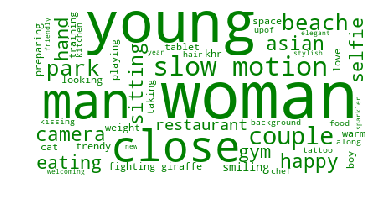

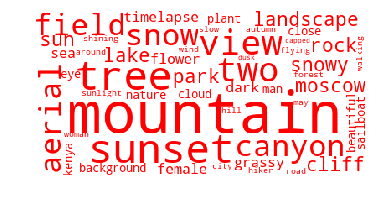

In [ ]:
word_string=" ".join(merged_faces_dataset.sort_values('short-term_memorability', ascending=False)[['caption']].head(50)['caption'].str.lower())
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=50, color_func=(lambda *args, **kwargs: (0,128,0))
                         ).generate(word_string)
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

word_string=" ".join(merged_faces_dataset.sort_values('short-term_memorability')[['caption']].head(50)['caption'].str.lower())
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=50, color_func=(lambda *args, **kwargs: (255,0,0))
                         ).generate(word_string)
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

From the above graphs we can see that most  of the videos having high short memoribility have words woman, couple, man in it, whereas videos with less memorability score have words like mountain, tree, etc in it. This might signify that human object is far more memorable than a landscape or nature related video. 

Let us see if this assumption holds true for long term memorability

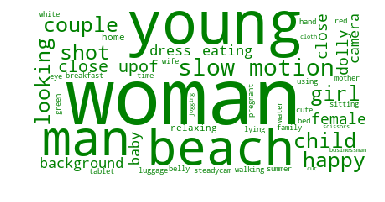

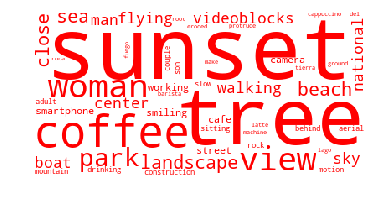

In [ ]:
word_string=" ".join(merged_faces_dataset.sort_values('long-term_memorability', ascending=False)[['caption']].head(50)['caption'].str.lower())
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=50, color_func=(lambda *args, **kwargs: (0,128,0))
                         ).generate(word_string)
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

word_string=" ".join(merged_faces_dataset.sort_values('long-term_memorability')[['caption']].head(50)['caption'].str.lower())
wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color='white', 
                      max_words=50, color_func=(lambda *args, **kwargs: (255,0,0))
                         ).generate(word_string)
plt.clf()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

We can see a similar pattern in long term as well

Let us see if short term memoribility and long term  memoribility follow the same pattern 

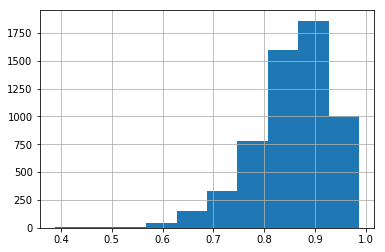

In [ ]:
merged_faces_dataset['short-term_memorability'].hist()

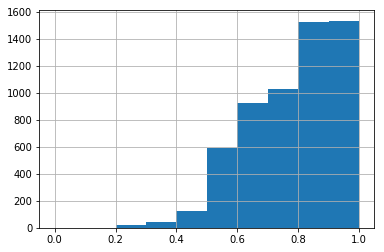

In [ ]:
merged_faces_dataset['long-term_memorability'].hist()

From the distributions we can see that both the distribution are skewed, they seem to follow a similar pattern. Videos are more memorable in short term than long term

## Building Model

Using k-fold cross validation technique on our model

In [ ]:
kf = KFold(n_splits=10)

NameError: ignored

Function to get the correlation value of a model 

In [ ]:
def get_corr_for_model(model, traing_caption, test_caption, y_train, y_test):
  model.fit(traing_caption, y_train)
  predictions_validation = model.predict(test_caption)
  corr, p_value = spearmanr(y_test, predictions_validation)
  return corr

Using the bag of words technique for vectorising our data, we can use the tfidf vectoriser as it gives a better performance than regular count vectoriser

In [ ]:
def vectorize_data(X_train, X_test):
  bow = TfidfVectorizer(max_features=1000, lowercase=True, ngram_range=(1,2),analyzer = "word")
  train_bow = bow.fit(X_train['caption'])
  train_caption = train_bow.transform(X_train['caption'])
  test_caption = train_bow.transform(X_test['caption'])
  return train_caption, test_caption

Separating the predictor and target variables

In [ ]:
training_set =  merged_faces_dataset.drop(columns=['short-term_memorability','long-term_memorability','nb_short-term_annotations','nb_long-term_annotations'])
testing_set_short_term = merged_faces_dataset['short-term_memorability'].to_frame()
testing_set_long_term = merged_faces_dataset['long-term_memorability'].to_frame()

Applying K-fold validation technique to evaluate the performance of our model.  The method get_corr_for_model returns the spearman rank score for each fold

### Caption based feature model

Comparing the results of Bayesian Ridge regression and Support Vector Regression for caption

In [ ]:
scores_svr_short_term = []
scores_svr_long_term = []
scores_BR_short_term = []
scores_BR_long_term = []

for train_index, test_index in kf.split(training_set):
  X_train, X_test, y_train, y_test =training_set.iloc[train_index, :], training_set.iloc[test_index, :],testing_set_long_term['long-term_memorability'][train_index],testing_set_long_term['long-term_memorability'][test_index]
  training_caption, testing_caption  = vectorize_data(X_train, X_test)
  scores_svr_long_term.append(get_corr_for_model(SVR(kernel='linear'), training_caption, testing_caption, y_train, y_test))
  scores_BR_long_term.append(get_corr_for_model(BayesianRidge(), training_caption.toarray(), testing_caption.toarray(), y_train, y_test))
  X_train, X_test, y_train, y_test =training_set.iloc[train_index, :], training_set.iloc[test_index, :],testing_set_short_term['short-term_memorability'][train_index],testing_set_short_term['short-term_memorability'][test_index]
  training_caption, testing_caption  = vectorize_data(X_train, X_test)
  scores_BR_short_term.append(get_corr_for_model(BayesianRidge(), training_caption.toarray(), testing_caption.toarray(), y_train, y_test))
  scores_svr_short_term.append(get_corr_for_model(SVR(kernel='linear'), training_caption, testing_caption, y_train, y_test))
  

Checking the average of the various scores

In [ ]:
avg_score_short_term_SVR = sum(scores_svr_short_term)/len(scores_svr_short_term)
print("average score for SVR short term memory = " + str(avg_score_short_term_SVR))
avg_score_long_term_SVR = sum(scores_svr_long_term)/len(scores_svr_long_term)
print("average score for SVR long term memory = " + str(avg_score_long_term_SVR))

avg_score_short_term_BR = sum(scores_BR_short_term)/len(scores_BR_short_term)
print("average score for Bayesian Ridge short term memory = " + str(avg_score_short_term_BR))
avg_score_long_term_BR = sum(scores_BR_long_term)/len(scores_BR_long_term)
print("average score for Bayesian Ridge long term memory = " + str(avg_score_long_term_BR))

average score for SVR short term memory = 0.31775879523649736
average score for SVR long term memory = 0.11978829002441187
average score for Bayesian Ridge short term memory = 0.4194609889617035
average score for Bayesian Ridge long term memory = 0.18636456612950641


Here we can see Bayesian Ridge is performing better on our dataset, Let us use that for our predictions of long and short term memoribility using text data 

### Video based features model

Now let us work with the video based features in our dataset 

Checking the correlation between the data

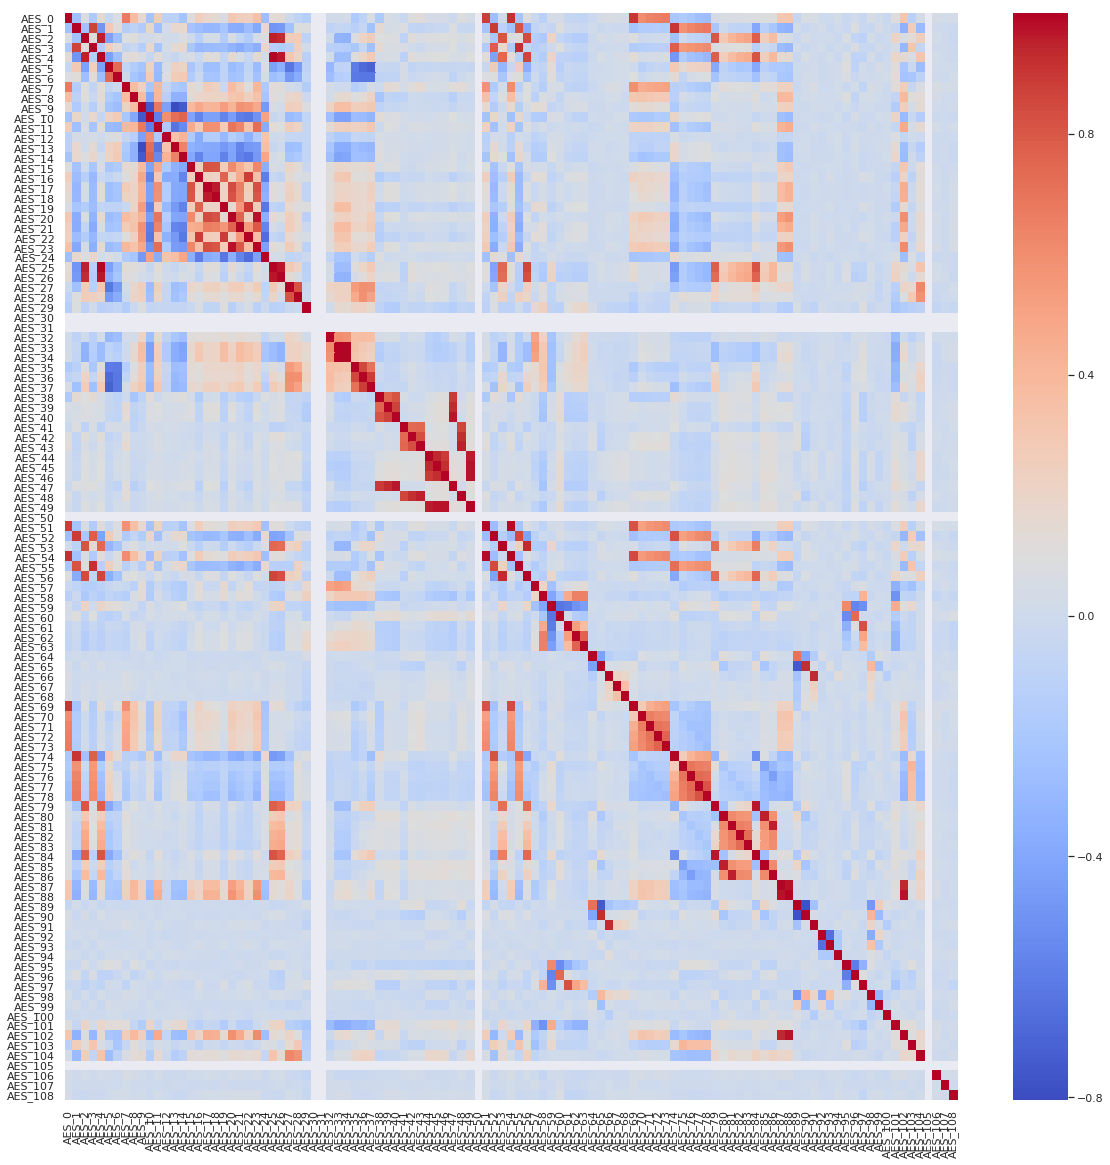

In [ ]:
corr_data = training_set.drop(columns='video')
corr_data_2 = corr_data[corr_data.columns[corr_data.columns.str.startswith('AES')]]
corre = corr_data_2.corr()
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(corre,
            cmap='coolwarm',
            xticklabels=corre.columns.values,
            yticklabels=corre.columns.values)


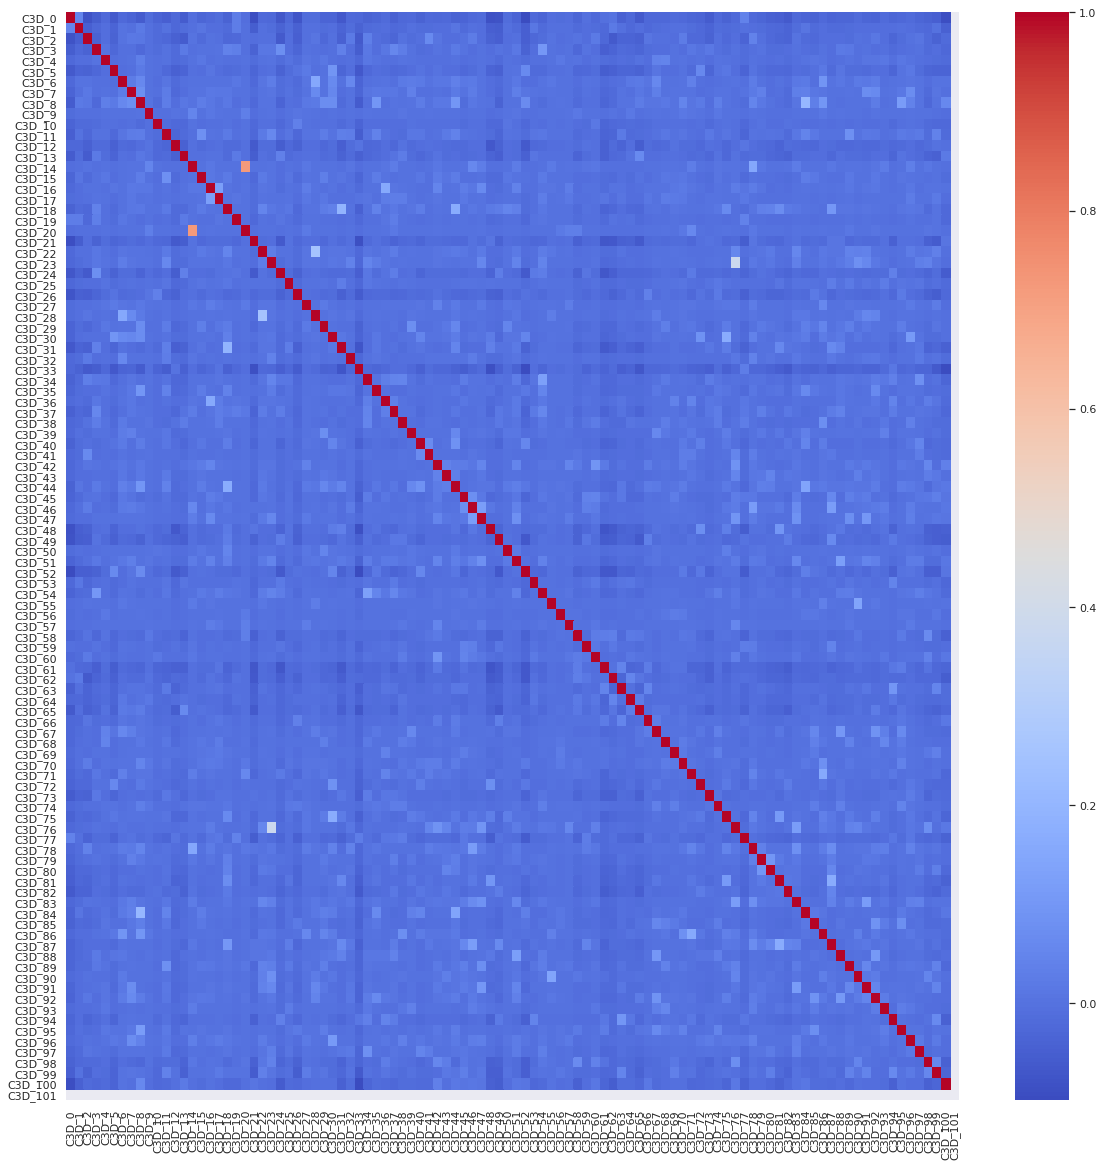

In [ ]:
corr_data = training_set.drop(columns='video')
corr_data_2 = corr_data[corr_data.columns[corr_data.columns.str.startswith('C3D')]]
corre = corr_data_2.corr()
sns.set(rc={'figure.figsize':(20,20)})
sns.heatmap(corre,
            cmap='coolwarm',
            xticklabels=corre.columns.values,
            yticklabels=corre.columns.values)


From the correlation matrix we can see that some of the variables have high correlation for Aesthetic values

**Aesthetic Features**

In [ ]:
Aesthetic_features = training_set[training_set.columns[training_set.columns.str.startswith('AES')]]

In [ ]:
Aesthetic_features.head()

,AES_0,AES_1,AES_2,AES_3,AES_4,AES_5,AES_6,AES_7,AES_8,AES_9,AES_10,AES_11,AES_12,AES_13,AES_14,AES_15,AES_16,AES_17,AES_18,AES_19,AES_20,AES_21,AES_22,AES_23,AES_24,AES_25,AES_26,AES_27,AES_28,AES_29,AES_30,AES_31,AES_32,AES_33,AES_34,AES_35,AES_36,AES_37,AES_38,AES_39,...,AES_69,AES_70,AES_71,AES_72,AES_73,AES_74,AES_75,AES_76,AES_77,AES_78,AES_79,AES_80,AES_81,AES_82,AES_83,AES_84,AES_85,AES_86,AES_87,AES_88,AES_89,AES_90,AES_91,AES_92,AES_93,AES_94,AES_95,AES_96,AES_97,AES_98,AES_99,AES_100,AES_101,AES_102,AES_103,AES_104,AES_105,AES_106,AES_107,AES_108
0,0.180874,0.715626,0.198930,0.610453,0.121610,0.692880,55.008914,0.103175,0.001049,2.0,17.0,0.05,0.5,0.519604,17.0,0.005960,0.008102,0.020343,0.770542,2.004125,0.021858,1.988820,2.013504,2.019222,9.0,0.120265,0.080634,40.0,119.0,0.735895,0.0,0.0,0.018776,0.019295,0.007748,6.274252,5.379075,4.642803,0.002215,0.042486,...,0.213352,0.095509,0.087230,0.033329,0.056038,0.662861,0.771214,0.829652,0.924071,0.927459,0.077285,0.360043,0.328821,0.143918,0.189463,0.120016,0.679751,0.598540,2.230930,2.230930,0.369616,0.704061,0.598133,0.495474,0.609570,0.048284,0.136023,0.080460,0.069851,0.009017,-0.002154,-0.000850,0.000000,0.260845,0.294153,0.575061,0.0,0.129661,0.412381,0.788761
1,0.146076,0.550070,0.460729,0.424397,0.341807,0.398212,47.307755,0.119048,0.001859,2.0,16.0,0.05,0.5,0.826721,17.0,0.574806,0.143842,2.256436,2.756384,1.086561,5.479923,2.133483,1.732435,9.536329,9.0,0.353469,0.293591,93.0,237.0,0.604444,0.0,0.0,0.026247,0.023164,0.008719,7.564623,7.510288,7.055773,0.011344,0.023777,...,0.117375,0.251914,0.313148,0.154196,0.159286,0.569429,0.512815,0.251813,0.315495,0.621390,0.506164,0.243233,0.236492,0.225829,0.175110,1.155411,0.626569,0.629879,3.518818,3.518818,0.516974,0.499703,0.529186,0.508357,0.452106,0.088257,0.156600,0.005414,0.011766,0.001006,0.000007,-0.000399,0.920270,0.337932,0.382134,0.943198,0.0,0.692224,0.762354,-0.561793
2,0.063898,0.827439,0.211925,0.720297,0.129499,0.722464,60.535453,0.069048,0.000423,1.0,18.0,0.00,0.5,0.925215,18.0,0.001088,0.007850,0.012946,0.503774,0.500744,0.011369,0.495924,0.504864,0.511403,9.0,0.122787,0.078270,30.0,114.0,0.752917,0.0,0.0,0.011631,0.010970,0.004174,6.816686,5.902598,4.611552,0.006431,-0.022721,...,0.061944,0.064526,0.068016,0.063560,0.067906,0.782612,0.915448,0.742627,0.929079,0.819570,0.325139,0.053818,0.292247,0.062686,0.096624,0.567694,0.083037,0.532664,0.172798,0.172798,0.444921,0.491387,0.482771,0.297088,0.630684,0.874500,0.098737,0.093660,0.086411,0.006172,0.002896,0.002309,0.374684,0.019155,0.187358,0.512601,0.0,0.438261,-0.219560,0.276687
3,0.427258,0.381448,0.582746,0.409475,0.489531,0.198180,39.394310,0.583333,0.039983,7.0,8.0,0.50,0.5,0.235256,9.0,3.353624,1.457271,9.106350,9.757566,6.015925,23.798947,8.782157,10.694530,42.722976,7.0,0.480419,0.391819,95.0,250.0,0.639182,0.0,0.0,0.047711,0.051303,0.019465,7.648013,7.741015,7.742093,0.005973,0.013943,...,0.350875,0.599704,0.724789,0.625646,0.501627,0.327160,0.598499,0.529061,0.531380,0.509560,0.671278,0.379598,0.262728,0.237663,0.244884,1.682174,0.814582,0.617273,5.050162,4.715430,0.581783,0.267555,0.548738,0.524388,0.302570,0.714883,0.157093,0.058108,0.008797,-0.006392,0.005307,0.000065,0.000000,0.442575,0.347355,1.285838,0.0,-0.279630,-0.012414,0.197281
4,0.280348,0.290578,0.511994,0.222889,0.450731,0.227978,40.753770,0.250000,0.011751,5.0,9.0,0.50,0.5,0.367784,12.0,2.614561,2.167235,15.000056,11.099259,16.905458,13.181638,13.953545,20.332098,31.681370,2.0,0.449567,0.391062,94.0,230.0,0.755255,0.0,0.0,0.047528,0.029033,0.010581,7.605905,7.637385,7.763148,-0.033414,-0.042541,...,0.349215,0.090216,0.241533,0.278792,0.240293,0.161017,0.578818,0.443661,0.335568,0.491287,0.620513,0.340944,0.445092,0.361349,0.301380,1.726577,0.719000,1.037653,2.358741,2.358741,0.528076,0.360151,0.506759,0.577685,0.619283,0.252510,0.150581,0.048709,0.082479,-0.002173,0.001612,-0.000050,0.187068,0.257831,0.470659,1.206474,0.0,0.460129,0.224915,0.068295


In [ ]:
X = Aesthetic_features

Applying K fold validation technique using Bayesian Ridge Regression on aesthetic features 

We are using Bayesian ridge regression as we have a variety of features and Bayesian ridge will regularize the data and apply bayesian probability to get our target variables

In [ ]:
scores_BR_short_term = []
scores_BR_long_term = []

for train_index, test_index in kf.split(X):
  X_train, X_test, y_train, y_test =X.iloc[train_index, :], X.iloc[test_index, :],testing_set_long_term['long-term_memorability'][train_index],testing_set_long_term['long-term_memorability'][test_index]
  scores_BR_long_term.append(get_corr_for_model(BayesianRidge(), X_train, X_test, y_train, y_test))
  X_train, X_test, y_train, y_test =X.iloc[train_index, :], X.iloc[test_index, :],testing_set_short_term['short-term_memorability'][train_index],testing_set_short_term['short-term_memorability'][test_index]
  scores_BR_short_term.append(get_corr_for_model(BayesianRidge(), X_train, X_test, y_train, y_test))

In [ ]:
avg_score_short_term_BR_AF = sum(scores_BR_short_term)/len(scores_BR_short_term)
print("average score for Bayesian Ridge short term memory = " + str(avg_score_short_term_BR_AF))
avg_score_long_term_BR_AF = sum(scores_BR_long_term)/len(scores_BR_long_term)
print("average score for Bayesian Ridge long term memory = " + str(avg_score_long_term_BR_AF))

average score for Bayesian Ridge short term memory = 0.2547266312808306
average score for Bayesian Ridge long term memory = 0.06484389217428371


## Facial Features 

In [ ]:
face_features = training_set[training_set.columns[training_set.columns.str.startswith('face')]]

NameError: ignored

In [ ]:
face_features#.head()

,face_found
0,0.000000
1,0.428571
2,1.000000
3,0.000000
4,0.000000
5,0.857143
6,0.000000
7,0.428571
8,0.142857
9,0.285714


In [ ]:
X = face_features
X

,face_found
0,0.000000
1,0.428571
2,1.000000
3,0.000000
4,0.000000
5,0.857143
6,0.000000
7,0.428571
8,0.142857
9,0.285714


In [ ]:
scores_BR_short_term = []
scores_BR_long_term = []

for train_index, test_index in kf.split(X):
  X_train, X_test, y_train, y_test =X.iloc[train_index, :], X.iloc[test_index, :],testing_set_long_term['long-term_memorability'][train_index],testing_set_long_term['long-term_memorability'][test_index]
  scores_BR_long_term.append(get_corr_for_model(BayesianRidge(), X_train, X_test, y_train, y_test))
  X_train, X_test, y_train, y_test =X.iloc[train_index, :], X.iloc[test_index, :],testing_set_short_term['short-term_memorability'][train_index],testing_set_short_term['short-term_memorability'][test_index]
  scores_BR_short_term.append(get_corr_for_model(BayesianRidge(), X_train, X_test, y_train, y_test))

In [ ]:
avg_score_short_term_BR_AF = sum(scores_BR_short_term)/len(scores_BR_short_term)
print("average score for Bayesian Ridge short term memory = " + str(avg_score_short_term_BR_AF))
avg_score_long_term_BR_AF = sum(scores_BR_long_term)/len(scores_BR_long_term)
print("average score for Bayesian Ridge long term memory = " + str(avg_score_long_term_BR_AF))

average score for Bayesian Ridge short term memory = 0.062194961976136255
average score for Bayesian Ridge long term memory = 0.03944110362724981


**C3D features**

Let us work on C3D features 

In [ ]:
C3D_features = training_set[training_set.columns[training_set.columns.str.startswith('C3D')]]

In [ ]:

C3D_features.drop(columns='C3D_101', inplace=True)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [ ]:
C3D_features = training_set[training_set.columns[training_set.columns.str.startswith('C3D')]]
C3D_features.drop(columns='C3D_101', inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [ ]:
C3D_features.head()

,C3D_0,C3D_1,C3D_2,C3D_3,C3D_4,C3D_5,C3D_6,C3D_7,C3D_8,C3D_9,C3D_10,C3D_11,C3D_12,C3D_13,C3D_14,C3D_15,C3D_16,C3D_17,C3D_18,C3D_19,C3D_20,C3D_21,C3D_22,C3D_23,C3D_24,C3D_25,C3D_26,C3D_27,C3D_28,C3D_29,C3D_30,C3D_31,C3D_32,C3D_33,C3D_34,C3D_35,C3D_36,C3D_37,C3D_38,C3D_39,...,C3D_61,C3D_62,C3D_63,C3D_64,C3D_65,C3D_66,C3D_67,C3D_68,C3D_69,C3D_70,C3D_71,C3D_72,C3D_73,C3D_74,C3D_75,C3D_76,C3D_77,C3D_78,C3D_79,C3D_80,C3D_81,C3D_82,C3D_83,C3D_84,C3D_85,C3D_86,C3D_87,C3D_88,C3D_89,C3D_90,C3D_91,C3D_92,C3D_93,C3D_94,C3D_95,C3D_96,C3D_97,C3D_98,C3D_99,C3D_100
0,0.020249,0.001578,0.000826,0.000945,0.000063,0.000003,0.001162,0.000097,0.000022,0.000010,0.000337,0.000636,1.111700e-04,0.001008,0.000004,0.000631,3.905000e-05,0.000041,0.000091,0.000303,1.541000e-05,0.000032,0.000052,0.000062,0.017465,0.000666,0.000065,0.000054,0.000273,0.001386,0.000003,0.001356,0.000517,0.002426,0.002719,2.770000e-06,0.001557,0.000249,0.002632,0.000093,...,0.096647,0.004458,0.011840,0.000287,0.002195,0.002792,0.000018,0.003365,0.000061,0.000573,0.000273,0.000034,0.006737,0.000021,0.000098,0.000025,0.005768,2.990000e-06,0.000085,0.000607,0.000461,0.001189,0.000270,0.000127,0.000106,0.000154,0.000567,0.000020,0.000894,0.001079,0.001042,0.000161,0.000257,0.046617,0.000156,0.000006,0.000537,0.000339,0.008437,0.000470
1,0.000118,0.000891,0.000188,0.000045,0.000063,0.000002,0.000641,0.000011,0.000017,0.000014,0.000336,0.004081,5.900000e-07,0.000411,0.000003,0.000243,6.600000e-07,0.000002,0.000535,0.000278,4.804000e-05,0.001153,0.000028,0.000040,0.022276,0.004529,0.000020,0.000029,0.000045,0.060436,0.000039,0.027208,0.000074,0.000027,0.000623,2.609600e-04,0.000183,0.000301,0.000102,0.012248,...,0.000372,0.000154,0.000148,0.000086,0.000267,0.000014,0.001430,0.004417,0.000064,0.000105,0.003129,0.000055,0.000061,0.000025,0.004283,0.000010,0.000062,2.903000e-05,0.000374,0.000139,0.741702,0.007178,0.000346,0.000104,0.000181,0.000052,0.004839,0.000078,0.042325,0.000623,0.000582,0.000393,0.000864,0.000947,0.000136,0.000007,0.000360,0.000159,0.001025,0.000020
2,0.011765,0.000746,0.000784,0.000013,0.000007,0.000028,0.000041,0.000014,0.000041,0.000083,0.000048,0.000080,1.066610e-03,0.000958,0.000011,0.000070,2.992000e-05,0.000038,0.000031,0.000008,9.700000e-07,0.002905,0.000018,0.000013,0.000192,0.000050,0.000532,0.000027,0.000051,0.000010,0.000005,0.000029,0.000033,0.032602,0.000034,7.100000e-07,0.000006,0.001313,0.000064,0.000002,...,0.876291,0.005509,0.008852,0.000399,0.000069,0.013166,0.000015,0.000044,0.000520,0.000046,0.000007,0.000024,0.010491,0.000475,0.000023,0.000006,0.005554,2.500000e-07,0.000057,0.000328,0.000149,0.001844,0.000008,0.000103,0.000030,0.000005,0.000179,0.000001,0.000006,0.000215,0.000224,0.000003,0.000031,0.002538,0.000104,0.000005,0.000064,0.005380,0.001027,0.001384
3,0.000090,0.000615,0.003436,0.001281,0.003551,0.000313,0.000042,0.000018,0.000157,0.000117,0.000256,0.000116,3.234800e-04,0.009888,0.000001,0.000576,3.004000e-05,0.000008,0.002029,0.000016,7.690000e-06,0.007324,0.000029,0.000015,0.035220,0.000153,0.001053,0.000031,0.000026,0.001376,0.000215,0.001759,0.000013,0.001699,0.000248,1.754577e-02,0.000260,0.000040,0.001630,0.000025,...,0.000236,0.000046,0.000027,0.000203,0.010644,0.000252,0.000349,0.001776,0.000006,0.001443,0.000146,0.019003,0.000584,0.000027,0.000692,0.000006,0.000403,2.894700e-04,0.000197,0.001254,0.005257,0.045808,0.000008,0.000296,0.003893,0.000318,0.000048,0.000018,0.000263,0.000026,0.000037,0.000690,0.000171,0.000231,0.000637,0.000040,0.000061,0.000075,0.000002,0.001323
4,0.093893,0.007010,0.008881,0.002135,0.000059,0.000078,0.000076,0.000212,0.000080,0.002659,0.000691,0.000095,1.962849e-02,0.025039,0.000012,0.001424,1.991050e-03,0.003423,0.000147,0.003180,3.400000e-06,0.000445,0.000043,0.000049,0.008997,0.000341,0.000700,0.000085,0.000040,0.000055,0.000007,0.004297,0.000080,0.414307,0.003316,1.265200e-04,0.002274,0.001550,0.039511,0.000034,...,0.075833,0.023165,0.001894,0.003120,0.002911,0.000956,0.000659,0.000148,0.0003

Applying Bayesian Ridge model on C3D features using KFold 

In [ ]:
X = C3D_features
scores_BR_short_term = []
scores_BR_long_term = []

for train_index, test_index in kf.split(X):
  X_train, X_test, y_train, y_test =X.iloc[train_index, :], X.iloc[test_index, :],testing_set_long_term['long-term_memorability'][train_index],testing_set_long_term['long-term_memorability'][test_index]
  scores_BR_long_term.append(get_corr_for_model(BayesianRidge(), X_train, X_test, y_train, y_test))
  X_train, X_test, y_train, y_test =X.iloc[train_index, :], X.iloc[test_index, :],testing_set_short_term['short-term_memorability'][train_index],testing_set_short_term['short-term_memorability'][test_index]
  scores_BR_short_term.append(get_corr_for_model(BayesianRidge(), X_train, X_test, y_train, y_test))

Checking scores of our model

In [ ]:
avg_score_short_term_BR_C3D = sum(scores_BR_short_term)/len(scores_BR_short_term)
print("average score for Bayesian Ridge short term memory = " + str(avg_score_short_term_BR_C3D))
avg_score_long_term_BR_C3D = sum(scores_BR_long_term)/len(scores_BR_long_term)
print("average score for Bayesian Ridge long term memory = " + str(avg_score_long_term_BR_C3D))

average score for Bayesian Ridge short term memory = 0.28224086723476105
average score for Bayesian Ridge long term memory = 0.1295980941398717


In [ ]:
Applying Bayesian Ridge model on Facial features using KFold

In [ ]:
C3D_features.head()

,C3D_0,C3D_1,C3D_2,C3D_3,C3D_4,C3D_5,C3D_6,C3D_7,C3D_8,C3D_9,C3D_10,C3D_11,C3D_12,C3D_13,C3D_14,C3D_15,C3D_16,C3D_17,C3D_18,C3D_19,C3D_20,C3D_21,C3D_22,C3D_23,C3D_24,C3D_25,C3D_26,C3D_27,C3D_28,C3D_29,C3D_30,C3D_31,C3D_32,C3D_33,C3D_34,C3D_35,C3D_36,C3D_37,C3D_38,C3D_39,...,C3D_61,C3D_62,C3D_63,C3D_64,C3D_65,C3D_66,C3D_67,C3D_68,C3D_69,C3D_70,C3D_71,C3D_72,C3D_73,C3D_74,C3D_75,C3D_76,C3D_77,C3D_78,C3D_79,C3D_80,C3D_81,C3D_82,C3D_83,C3D_84,C3D_85,C3D_86,C3D_87,C3D_88,C3D_89,C3D_90,C3D_91,C3D_92,C3D_93,C3D_94,C3D_95,C3D_96,C3D_97,C3D_98,C3D_99,C3D_100
0,0.020249,0.001578,0.000826,0.000945,0.000063,0.000003,0.001162,0.000097,0.000022,0.000010,0.000337,0.000636,1.111700e-04,0.001008,0.000004,0.000631,3.905000e-05,0.000041,0.000091,0.000303,1.541000e-05,0.000032,0.000052,0.000062,0.017465,0.000666,0.000065,0.000054,0.000273,0.001386,0.000003,0.001356,0.000517,0.002426,0.002719,2.770000e-06,0.001557,0.000249,0.002632,0.000093,...,0.096647,0.004458,0.011840,0.000287,0.002195,0.002792,0.000018,0.003365,0.000061,0.000573,0.000273,0.000034,0.006737,0.000021,0.000098,0.000025,0.005768,2.990000e-06,0.000085,0.000607,0.000461,0.001189,0.000270,0.000127,0.000106,0.000154,0.000567,0.000020,0.000894,0.001079,0.001042,0.000161,0.000257,0.046617,0.000156,0.000006,0.000537,0.000339,0.008437,0.000470
1,0.000118,0.000891,0.000188,0.000045,0.000063,0.000002,0.000641,0.000011,0.000017,0.000014,0.000336,0.004081,5.900000e-07,0.000411,0.000003,0.000243,6.600000e-07,0.000002,0.000535,0.000278,4.804000e-05,0.001153,0.000028,0.000040,0.022276,0.004529,0.000020,0.000029,0.000045,0.060436,0.000039,0.027208,0.000074,0.000027,0.000623,2.609600e-04,0.000183,0.000301,0.000102,0.012248,...,0.000372,0.000154,0.000148,0.000086,0.000267,0.000014,0.001430,0.004417,0.000064,0.000105,0.003129,0.000055,0.000061,0.000025,0.004283,0.000010,0.000062,2.903000e-05,0.000374,0.000139,0.741702,0.007178,0.000346,0.000104,0.000181,0.000052,0.004839,0.000078,0.042325,0.000623,0.000582,0.000393,0.000864,0.000947,0.000136,0.000007,0.000360,0.000159,0.001025,0.000020
2,0.011765,0.000746,0.000784,0.000013,0.000007,0.000028,0.000041,0.000014,0.000041,0.000083,0.000048,0.000080,1.066610e-03,0.000958,0.000011,0.000070,2.992000e-05,0.000038,0.000031,0.000008,9.700000e-07,0.002905,0.000018,0.000013,0.000192,0.000050,0.000532,0.000027,0.000051,0.000010,0.000005,0.000029,0.000033,0.032602,0.000034,7.100000e-07,0.000006,0.001313,0.000064,0.000002,...,0.876291,0.005509,0.008852,0.000399,0.000069,0.013166,0.000015,0.000044,0.000520,0.000046,0.000007,0.000024,0.010491,0.000475,0.000023,0.000006,0.005554,2.500000e-07,0.000057,0.000328,0.000149,0.001844,0.000008,0.000103,0.000030,0.000005,0.000179,0.000001,0.000006,0.000215,0.000224,0.000003,0.000031,0.002538,0.000104,0.000005,0.000064,0.005380,0.001027,0.001384
3,0.000090,0.000615,0.003436,0.001281,0.003551,0.000313,0.000042,0.000018,0.000157,0.000117,0.000256,0.000116,3.234800e-04,0.009888,0.000001,0.000576,3.004000e-05,0.000008,0.002029,0.000016,7.690000e-06,0.007324,0.000029,0.000015,0.035220,0.000153,0.001053,0.000031,0.000026,0.001376,0.000215,0.001759,0.000013,0.001699,0.000248,1.754577e-02,0.000260,0.000040,0.001630,0.000025,...,0.000236,0.000046,0.000027,0.000203,0.010644,0.000252,0.000349,0.001776,0.000006,0.001443,0.000146,0.019003,0.000584,0.000027,0.000692,0.000006,0.000403,2.894700e-04,0.000197,0.001254,0.005257,0.045808,0.000008,0.000296,0.003893,0.000318,0.000048,0.000018,0.000263,0.000026,0.000037,0.000690,0.000171,0.000231,0.000637,0.000040,0.000061,0.000075,0.000002,0.001323
4,0.093893,0.007010,0.008881,0.002135,0.000059,0.000078,0.000076,0.000212,0.000080,0.002659,0.000691,0.000095,1.962849e-02,0.025039,0.000012,0.001424,1.991050e-03,0.003423,0.000147,0.003180,3.400000e-06,0.000445,0.000043,0.000049,0.008997,0.000341,0.000700,0.000085,0.000040,0.000055,0.000007,0.004297,0.000080,0.414307,0.003316,1.265200e-04,0.002274,0.001550,0.039511,0.000034,...,0.075833,0.023165,0.001894,0.003120,0.002911,0.000956,0.000659,0.000148,0.0003

**Bayesian Ridge on combined dataset (captions + aesthetic + C3D)**

We can see that Bayesian ridge is performing well for C3D, Aesthetic and captions individually. Let us try to run Bayesian Ridge on the complete model

In [ ]:
X=training_set.drop(columns='video')

scores_BR_short_term = []
scores_BR_long_term = []

for train_index, test_index in kf.split(X):
  X_train, X_test, y_train, y_test =X.iloc[train_index, :], X.iloc[test_index, :],testing_set_long_term['long-term_memorability'][train_index],testing_set_long_term['long-term_memorability'][test_index]
  training_caption, testing_caption  = vectorize_data(X_train[['caption']], X_test[['caption']])
  X_train = X_train.drop(columns='caption')
  X_test = X_test.drop(columns='caption')
  final_train = sp.sparse.hstack((training_caption,X_train.values.astype(float)),format='csr')
  final_test = sp.sparse.hstack((testing_caption,X_test.values),format='csr')
  scores_BR_long_term.append(get_corr_for_model(BayesianRidge(), final_train.toarray(), final_test.toarray(), y_train, y_test))
  X_train, X_test, y_train, y_test =X.iloc[train_index, :], X.iloc[test_index, :],testing_set_short_term['short-term_memorability'][train_index],testing_set_short_term['short-term_memorability'][test_index]
  training_caption, testing_caption  = vectorize_data(X_train[['caption']], X_test[['caption']])
  X_train = X_train.drop(columns='caption')
  X_test = X_test.drop(columns='caption')
  
  final_train = sp.sparse.hstack((training_caption,X_train.values.astype(float)),format='csr')
  final_test = sp.sparse.hstack((testing_caption,X_test.values.astype(float)),format='csr')
  scores_BR_short_term.append(get_corr_for_model(BayesianRidge(), final_train.toarray(), final_test.toarray(), y_train, y_test))

ValueError: ignored

Checking average score 

In [ ]:
avg_score_short_term_BR_combined = sum(scores_BR_short_term)/len(scores_BR_short_term)
print("average score for Bayesian Ridge short term memory = " + str(avg_score_short_term_BR_combined))
avg_score_long_term_BR_combined = sum(scores_BR_long_term)/len(scores_BR_long_term)
print("average score for Bayesian Ridge long term memory = " + str(avg_score_long_term_BR_combined))

average score for Bayesian Ridge short term memory = 0.43186046608351847
average score for Bayesian Ridge long term memory = 0.17190469249258145


From the results, we can see that our short term memoribility score has improved, but our long term memory score has reduced compared to the score of just captions. By applying an ensemble technique I wil be able to assign weights to my models and use it for prediction. Hence applying ensemble technique using weighted average technique

### **Ensemble model building**

Function to build model on captions

In [ ]:
def model_for_captions(X_train, X_test, y_train, y_test):
  training_caption, testing_caption  = vectorize_data(X_train[['caption']], X_test[['caption']])
  model = BayesianRidge()
  model.fit(training_caption.toarray(), y_train)
  predictions_validation = model.predict(testing_caption.toarray())
  return predictions_validation

Function to build model on Aesthetics

In [ ]:
def model_for_AES(X_train, X_test, y_train, y_test):
  Aesthetic_features_train = X_train[X_train.columns[X_train.columns.str.startswith('AES')]]
  Aesthetic_features_test = X_test[X_test.columns[X_test.columns.str.startswith('AES')]]
  model = BayesianRidge()
  model.fit(Aesthetic_features_train, y_train)
  predictions_validation = model.predict(Aesthetic_features_test)
  return predictions_validation

Function to build model on C3D

In [ ]:
def model_for_C3D(X_train, X_test, y_train, y_test):
  C3D_features_train = X_train[X_train.columns[X_train.columns.str.startswith('C3D')]]
  C3D_features_test = X_test[X_test.columns[X_test.columns.str.startswith('C3D')]]
  model = BayesianRidge()
  model.fit(C3D_features_train, y_train)
  predictions_validation = model.predict(C3D_features_test)
  return predictions_validation

Function to model for long term memorability

In [ ]:
def predict_for_long_term(X_train, X_test, y_train, y_test):
  predictions_for_captions_long_term = model_for_captions(X_train, X_test, y_train, y_test)
  predictions_for_AES_long_term =  model_for_AES(X_train, X_test, y_train, y_test)
  predictions_for_C3D_long_term = model_for_C3D(X_train, X_test, y_train, y_test)
  Prediction_final = 0.5*predictions_for_captions_long_term + 0.1*predictions_for_AES_long_term + 0.4*predictions_for_C3D_long_term
  return Prediction_final

Function to model for short term memorability

In [ ]:
def predict_for_short_term(X_train, X_test, y_train, y_test):
  predictions_for_captions_short_term = model_for_captions(X_train, X_test, y_train, y_test)
  predictions_for_AES_short_term =  model_for_AES(X_train, X_test, y_train, y_test)
  predictions_for_C3D_short_term = model_for_C3D(X_train, X_test, y_train, y_test)
  Prediction_final = 0.6*predictions_for_captions_short_term + 0.1*predictions_for_AES_short_term + 0.3*predictions_for_C3D_short_term
  return Prediction_final

Function to get Spearman correlation value for the results

In [ ]:
def get_spearman_correlation(Predictions,y_test):
  corr, p_value = spearmanr(y_test, Predictions)
  return corr

Applying KFolds technique

In [ ]:
kf_ensemble = KFold(n_splits=10)

Applying ensemble model on training and validation set 

In [ ]:
X=training_set.drop(columns='video')

scores_BR_short_term = []
scores_BR_long_term = []

for train_index, test_index in kf_ensemble.split(X):
  X_train, X_test, y_train, y_test =X.iloc[train_index, :], X.iloc[test_index, :],testing_set_long_term['long-term_memorability'][train_index],testing_set_long_term['long-term_memorability'][test_index]
  Prediction_final_long_term = predict_for_long_term(X_train, X_test, y_train, y_test)
  scores_BR_long_term.append(get_spearman_correlation(Prediction_final_long_term,y_test))
  X_train, X_test, y_train, y_test =X.iloc[train_index, :], X.iloc[test_index, :],testing_set_short_term['short-term_memorability'][train_index],testing_set_short_term['short-term_memorability'][test_index]
  Prediction_final_short_term = predict_for_short_term(X_train, X_test, y_train, y_test)
  scores_BR_short_term.append(get_spearman_correlation(Prediction_final_short_term,y_test))

ValueError: ignored

Getting the average score, various simulations were run to find the optimal value for the weights

In [ ]:
# weights 0.8, 0.1, 0.1 --- captions, AES, C3D
avg_score_short_term_BR_ensemble = sum(scores_BR_short_term)/len(scores_BR_short_term)
print("average score for Bayesian Ridge short term memory ensemble model = " + str(avg_score_short_term_BR_ensemble))
avg_score_long_term_BR_ensemble = sum(scores_BR_long_term)/len(scores_BR_long_term)
print("average score for Bayesian Ridge long term memory ensemble model = " + str(avg_score_long_term_BR_ensemble))

average score for Bayesian Ridge short term memory ensemble model = 0.43419179985606043
average score for Bayesian Ridge long term memory ensemble model = 0.19203225560356804


In [ ]:
# weights 0.75, 0.1, 0.15 --- captions, AES, C3D
avg_score_short_term_BR_ensemble = sum(scores_BR_short_term)/len(scores_BR_short_term)
print("average score for Bayesian Ridge short term memory ensemble model = " + str(avg_score_short_term_BR_ensemble))
avg_score_long_term_BR_ensemble = sum(scores_BR_long_term)/len(scores_BR_long_term)
print("average score for Bayesian Ridge long term memory ensemble model = " + str(avg_score_long_term_BR_ensemble))

average score for Bayesian Ridge short term memory ensemble model = 0.42962736261974704
average score for Bayesian Ridge long term memory ensemble model = 0.18794565329151797


In [ ]:
# weights 0.7, 0.1, 0.2 --- captions, AES, C3D
## weights 0.7, 0.1, 0.2 --- captions, AES, C3D
avg_score_short_term_BR_ensemble = sum(scores_BR_short_term)/len(scores_BR_short_term)
print("average score for Bayesian Ridge short term memory ensemble model = " + str(avg_score_short_term_BR_ensemble))
avg_score_long_term_BR_ensemble = sum(scores_BR_long_term)/len(scores_BR_long_term)
print("average score for Bayesian Ridge long term memory ensemble model = " + str(avg_score_long_term_BR_ensemble))

average score for Bayesian Ridge short term memory ensemble model = 0.43111085340847766
average score for Bayesian Ridge long term memory ensemble model = 0.19027671372724494


In [ ]:
# weights 0.6, 0.1, 0.3 --- captions, AES, C3D
## weights 0.6, 0.1, 0.3 --- captions, AES, C3D
avg_score_short_term_BR_ensemble = sum(scores_BR_short_term)/len(scores_BR_short_term)
print("average score for Bayesian Ridge short term memory ensemble model = " + str(avg_score_short_term_BR_ensemble))
avg_score_long_term_BR_ensemble = sum(scores_BR_long_term)/len(scores_BR_long_term)
print("average score for Bayesian Ridge long term memory ensemble model = " + str(avg_score_long_term_BR_ensemble))

average score for Bayesian Ridge short term memory ensemble model = 0.4313648816350559
average score for Bayesian Ridge long term memory ensemble model = 0.1928586196951872


In [ ]:
# weights 0.5, 0.1, 0.4 --- captions, AES, C3D
## weights 0.5, 0.1, 0.4 --- captions, AES, C3D
avg_score_short_term_BR_ensemble = sum(scores_BR_short_term)/len(scores_BR_short_term)
print("average score for Bayesian Ridge short term memory ensemble model = " + str(avg_score_short_term_BR_ensemble))
avg_score_long_term_BR_ensemble = sum(scores_BR_long_term)/len(scores_BR_long_term)
print("average score for Bayesian Ridge long term memory ensemble model = " + str(avg_score_long_term_BR_ensemble))

average score for Bayesian Ridge short term memory ensemble model = 0.42827951623331395
average score for Bayesian Ridge long term memory ensemble model = 0.19472022650874357


We can see that our performance for long term increased but short term deteriorated, hence we should use weights 0.6, 0.1, 0.3 for short term, and 0.5, 0.1 and 0.4 for long term

In [ ]:
# weights 0.6, 0.1, 0.3 --- captions, AES, C3D
## weights 0.5, 0.1, 0.4 --- captions, AES, C3D
avg_score_short_term_BR_ensemble = sum(scores_BR_short_term)/len(scores_BR_short_term)
print("average score for Bayesian Ridge short term memory ensemble model = " + str(avg_score_short_term_BR_ensemble))
avg_score_long_term_BR_ensemble = sum(scores_BR_long_term)/len(scores_BR_long_term)
print("average score for Bayesian Ridge long term memory ensemble model = " + str(avg_score_long_term_BR_ensemble))

average score for Bayesian Ridge short term memory ensemble model = 0.4388558251299168
average score for Bayesian Ridge long term memory ensemble model = 0.19872778054890566


Now that I have decided weights for my model, we will go forward and predict for our test data set that has been shared to us without the target variables  

## Model on Test Data

Loading our test data 

In [ ]:
drive.mount('/content/drive/', force_remount=True)
os.chdir("/content/drive/My Drive/")

Mounted at /content/drive/


In [ ]:
path="/content/drive/My Drive/CA684_Assignment_Data/test-set/aesthetic_vis_features_test/median/"
files = reading_file_names(path)
dataframe_aesthetic_test = pd.DataFrame()
for filename in files:
  dataframe_aesthetic_test = read_features_from_file(dataframe_aesthetic_test, filename)

total files read = 2000


In [ ]:
new_columns = list()
for colname in dataframe_aesthetic_test.columns:
  new_columns.append('AES_' + str(colname))
dataframe_aesthetic_test.columns = new_columns
dataframe_aesthetic_test = dataframe_aesthetic_test.rename(columns={'AES_video':'video'})

In [ ]:
dataframe_aesthetic_test.head()

,AES_0,AES_1,AES_2,AES_3,AES_4,AES_5,AES_6,AES_7,AES_8,AES_9,...,AES_100,AES_101,AES_102,AES_103,AES_104,AES_105,AES_106,AES_107,AES_108,video
0,0.270589,0.354729,0.516568,0.303221,0.446719,0.251911,41.882477,0.102564,0.014481,7.0,...,0.000031,0.072940,0.382474,0.531038,1.933607,0.0,-0.610044,0.356858,-0.018747,video9901.webm
1,0.071170,0.646879,0.600170,0.636162,0.429450,0.352698,50.375382,0.083333,0.003462,1.0,...,-0.000569,0.717446,0.043435,0.393597,1.490415,0.0,0.039880,0.712733,1.289268,video8561.webm
2,0.587458,0.326311,0.507446,0.399857,0.432789,0.282504,43.665699,0.611111,0.013566,3.0,...,-0.000003,0.016111,0.133481,0.234052,1.650592,0.0,0.805432,0.134323,0.339574,video8554.webm
3,0.341185,0.251274,0.548991,0.296381,0.493898,0.254785,46.605301,0.583333,0.012088,2.0,...,0.002806,0.278534,0.438014,0.241516,2.065453,0.0,0.085207,0.277910,0.459928,video8546.webm
4,0.112613,0.277869,0.537006,0.197711,0.461235,0.287246,44.554962,0.166667,0.001334,3.0,...,-0.001477,0.009622,0.016891,0.123139,0.861777,0.0,-0.081865,0.049326,0.419058,video8668.webm


Reading test caption data 

In [ ]:
os.chdir("/content/drive/My Drive/CA684_Assignment_Data/test-set/")

In [ ]:
dataframe_captions_test = pd.read_csv('test-set-1_video-captions.txt', sep='\t',names = ['video','caption'])

In [ ]:
dataframe_captions_test.head()

,video,caption
0,video7494.webm,green-jeep-struggling-to-drive-over-huge-rocks
1,video7495.webm,hiking-woman-tourist-is-walking-forward-in-mou...
2,video7496.webm,close-up-of-african-american-doctors-hands-usi...
3,video7497.webm,slow-motion-of-a-man-using-treadmill-in-the-gy...
4,video7498.webm,slow-motion-of-photographer-in-national-park


Reading C3D data

In [ ]:
os.chdir("/content/drive/My Drive/CA684_Assignment_Data/test-set/C3D_test/")

In [ ]:
path="/content/drive/My Drive/CA684_Assignment_Data/test-set/C3D_test/"
files = reading_file_names(path)
dataframe_c3d_test = pd.DataFrame()
for filename in files:
  dataframe_c3d_test = read_c3d_from_file(dataframe_c3d_test, filename)

total files read = 2000


In [ ]:
new_columns = list()
for colname in dataframe_c3d_test.columns:
  new_columns.append('C3D_' + str(colname))
dataframe_c3d_test.columns = new_columns
dataframe_c3d_test = dataframe_c3d_test.rename(columns={'C3D_video':'video'})

In [ ]:
dataframe_c3d_test.drop(columns='C3D_101', inplace=True)

NameError: ignored

In [ ]:
dataframe_c3d_test.head()

,C3D_0,C3D_1,C3D_2,C3D_3,C3D_4,C3D_5,C3D_6,C3D_7,C3D_8,C3D_9,...,C3D_92,C3D_93,C3D_94,C3D_95,C3D_96,C3D_97,C3D_98,C3D_99,C3D_100,video
0,0.663500,0.018277,1.381600e-04,1.000000e-07,9.000000e-08,7.900000e-07,0.000010,3.960000e-06,0.000014,0.000005,...,7.000000e-07,4.600000e-07,4.947800e-04,0.000001,1.300000e-07,1.210000e-06,5.594800e-04,0.010371,0.000009,video9909.webm
1,0.000900,0.000011,1.926040e-03,2.700000e-07,1.889600e-04,1.806000e-05,0.000003,2.900000e-07,0.000002,0.000403,...,6.710000e-06,1.305590e-03,6.967230e-03,0.000012,1.300000e-07,3.009000e-04,1.082000e-05,0.000009,0.000273,video9908.webm
2,0.002532,0.002872,4.059100e-04,2.844000e-05,6.084000e-05,3.980000e-05,0.000023,1.442980e-03,0.000666,0.000043,...,1.442330e-03,1.129760e-03,1.813120e-03,0.000271,2.311000e-05,2.909000e-05,3.329000e-05,0.000360,0.000076,video9881.webm
3,0.000033,0.001178,6.100000e-07,1.250000e-06,6.100000e-07,9.200000e-07,0.000126,7.180000e-06,0.000257,0.000002,...,5.700000e-07,5.000000e-08,1.000000e-07,0.000022,6.000000e-08,1.400000e-07,2.200000e-07,0.000001,0.132085,video9875.webm
4,0.000156,0.000031,1.002700e-04,6.776900e-04,1.560000e-05,4.020000e-06,0.000006,8.280000e-06,0.000002,0.000014,...,1.620000e-06,3.210000e-06,1.682280e-03,0.000104,4.217000e-05,2.894700e-04,7.764000e-05,0.000843,0.000956,video9858.webm


Reading Ground Truth data 

In [ ]:
os.chdir("/content/drive/My Drive/CA684_Assignment_Data/test-set")

In [ ]:
dataframe_ground_truth_test = pd.read_csv('ground_truth_template.csv')
dataframe_ground_truth_test.head()

FileNotFoundError: ignored

function to add prefix and suffin ground truth data

In [ ]:
def change_video_name(val):
  val = 'video' +str(val) + '.webm' 
  return val

In [ ]:
def change_video_name_remove(val):
  val = str(val)[str(val).find('o')+1:str(val).find('.')]
  return val

adding prefix and suffix to 'video' column values in ground truth, so that we can merge with test_data_set

In [ ]:
dataframe_ground_truth_test['video'] = dataframe_ground_truth_test['video'].apply(change_video_name)

Merging to get final test dataset

In [ ]:
test_data_set = dataframe_aesthetic_test.merge(dataframe_c3d_test)
test_data_set = test_data_set.merge(dataframe_captions_test)
test_data_set = test_data_set.merge(dataframe_ground_truth_test)

In [ ]:
test_data_set.head(2)

,AES_0,AES_1,AES_2,AES_3,AES_4,AES_5,AES_6,AES_7,AES_8,AES_9,...,C3D_96,C3D_97,C3D_98,C3D_99,C3D_100,caption,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,0.270589,0.354729,0.516568,0.303221,0.446719,0.251911,41.882477,0.102564,0.014481,7.0,...,5.700000e-07,0.00001,0.000156,1.233703e-02,0.00023,chinese-businessman-commuter-walking-to-office...,NaN,33,NaN,10
1,0.071170,0.646879,0.600170,0.636162,0.429450,0.352698,50.375382,0.083333,0.003462,1.0,...,0.000000e+00,0.00000,0.000000,1.000000e-08,0.00000,trendy-woman-walks-up-to-camera-and-smiles,NaN,55,NaN,14


cleaning caption data in  test

In [ ]:
test_data_set['caption'] = cleaning_captions(test_data_set)

In [ ]:
test_data_set[['caption']].head(3)

,caption
0,chinese businessman commuter walking office bu...
1,trendy woman walk camera smile
2,panning view rally crowd


**Building model**

Now we have our final dataset, Now we can train the model that we have created before on the complete training set and get our predictions

In [ ]:
X_training_set =  merged_faces_dataset.drop(columns=['short-term_memorability', 'nb_short-term_annotations','long-term_memorability','nb_long-term_annotations','video'])
Y_training_set = merged_faces_dataset[['short-term_memorability', 'long-term_memorability']]

In [ ]:
X_training_set.head(2)

,caption,AES_0,AES_1,AES_2,AES_3,AES_4,AES_5,AES_6,AES_7,AES_8,AES_9,AES_10,AES_11,AES_12,AES_13,AES_14,AES_15,AES_16,AES_17,AES_18,AES_19,AES_20,AES_21,AES_22,AES_23,AES_24,AES_25,AES_26,AES_27,AES_28,AES_29,AES_30,AES_31,AES_32,AES_33,AES_34,AES_35,AES_36,AES_37,AES_38,...,C3D_62,C3D_63,C3D_64,C3D_65,C3D_66,C3D_67,C3D_68,C3D_69,C3D_70,C3D_71,C3D_72,C3D_73,C3D_74,C3D_75,C3D_76,C3D_77,C3D_78,C3D_79,C3D_80,C3D_81,C3D_82,C3D_83,C3D_84,C3D_85,C3D_86,C3D_87,C3D_88,C3D_89,C3D_90,C3D_91,C3D_92,C3D_93,C3D_94,C3D_95,C3D_96,C3D_97,C3D_98,C3D_99,C3D_100,C3D_101
0,blonde woman massaged tilt,0.180874,0.715626,0.198930,0.610453,0.121610,0.692880,55.008914,0.103175,0.001049,2.0,17.0,0.05,0.5,0.519604,17.0,0.005960,0.008102,0.020343,0.770542,2.004125,0.021858,1.988820,2.013504,2.019222,9.0,0.120265,0.080634,40.0,119.0,0.735895,0.0,0.0,0.018776,0.019295,0.007748,6.274252,5.379075,4.642803,0.002215,...,0.004458,0.011840,0.000287,0.002195,0.002792,0.000018,0.003365,0.000061,0.000573,0.000273,0.000034,0.006737,0.000021,0.000098,0.000025,0.005768,0.000003,0.000085,0.000607,0.000461,0.001189,0.000270,0.000127,0.000106,0.000154,0.000567,0.000020,0.000894,0.001079,0.001042,0.000161,0.000257,0.046617,0.000156,0.000006,0.000537,0.000339,0.008437,0.00047,NaN
1,roulette table spinning ball closeup shot,0.146076,0.550070,0.460729,0.424397,0.341807,0.398212,47.307755,0.119048,0.001859,2.0,16.0,0.05,0.5,0.826721,17.0,0.574806,0.143842,2.256436,2.756384,1.086561,5.479923,2.133483,1.732435,9.536329,9.0,0.353469,0.293591,93.0,237.0,0.604444,0.0,0.0,0.026247,0.023164,0.008719,7.564623,7.510288,7.055773,0.011344,...,0.000154,0.000148,0.000086,0.000267,0.000014,0.001430,0.004417,0.000064,0.000105,0.003129,0.000055,0.000061,0.000025,0.004283,0.000010,0.000062,0.000029,0.000374,0.000139,0.741702,0.007178,0.000346,0.000104,0.000181,0.000052,0.004839,0.000078,0.042325,0.000623,0.000582,0.000393,0.000864,0.000947,0.000136,0.000007,0.000360,0.000159,0.001025,0.00002,NaN


In [ ]:
X_testing_set = test_data_set.drop(columns=['short-term_memorability','long-term_memorability','nb_short-term_annotations','nb_long-term_annotations','video'])
Y_testing_set = test_data_set[['short-term_memorability','long-term_memorability']]

NameError: ignored

building a dataframe which will store our predictions

In [ ]:
Predictions = pd.DataFrame()
Predictions['video'] = test_data_set['video']

NameError: ignored

In [ ]:
print(X_testing_set.shape)
print(Y_testing_set.shape)

NameError: ignored

Applying our model

In [ ]:
X_train, X_test, y_train, y_test = X_training_set, X_testing_set, Y_training_set['long-term_memorability'],Y_testing_set['long-term_memorability']
Predictions['long-term_memorability'] = predict_for_long_term(X_train, X_test, y_train, y_test)
X_train, X_test, y_train, y_test = X_training_set, X_testing_set, Y_training_set['short-term_memorability'],Y_testing_set['short-term_memorability']
Predictions['short-term_memorability'] = predict_for_short_term(X_train, X_test, y_train, y_test)

NameError: ignored

checking our predictions

In [ ]:
Predictions.head()

,video,long-term_memorability,short-term_memorability
0,video9901.webm,0.785049,0.868050
1,video8561.webm,0.800809,0.906020
2,video8554.webm,0.767544,0.813926
3,video8546.webm,0.779855,0.872924
4,video8668.webm,0.780351,0.865848


removing video prefix and suffix to match with the ground truth template

In [ ]:
Predictions['video'] = Predictions['video'].apply(change_video_name_remove)

In [ ]:
dataframe_ground_truth_test['video'] = dataframe_ground_truth_test['video'].apply(change_video_name_remove)

In [ ]:
Predictions.head()

,video,long-term_memorability,short-term_memorability
0,9901,0.785049,0.868050
1,8561,0.800809,0.906020
2,8554,0.767544,0.813926
3,8546,0.779855,0.872924
4,8668,0.780351,0.865848


In [ ]:
dataframe_ground_truth_test.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,NaN,33,NaN,12
1,7495,NaN,34,NaN,10
2,7496,NaN,32,NaN,13
3,7497,NaN,33,NaN,10
4,7498,NaN,33,NaN,10


In [ ]:
dataframe_ground_truth_test = dataframe_ground_truth_test.drop(columns=['long-term_memorability','short-term_memorability'])

Merging our predictions with ground truth

In [ ]:
dataframe_ground_truth_test = dataframe_ground_truth_test.merge(Predictions)

In [ ]:
dataframe_ground_truth_test.head()

,video,nb_short-term_annotations,nb_long-term_annotations,long-term_memorability,short-term_memorability
0,7494,33,12,0.778246,0.851348
1,7495,34,10,0.756611,0.792997
2,7496,32,13,0.814712,0.907615
3,7497,33,10,0.782705,0.881360
4,7498,33,10,0.761416,0.852007


Arranging columns as per template

In [ ]:
dataframe_ground_truth_test = dataframe_ground_truth_test[['video','short-term_memorability','nb_short-term_annotations','long-term_memorability','nb_long-term_annotations']]

In [ ]:
dataframe_ground_truth_test.head()

,video,short-term_memorability,nb_short-term_annotations,long-term_memorability,nb_long-term_annotations
0,7494,0.851348,33,0.778246,12
1,7495,0.792997,34,0.756611,10
2,7496,0.907615,32,0.814712,13
3,7497,0.881360,33,0.782705,10
4,7498,0.852007,33,0.761416,10


Storing our result

In [ ]:
drive.mount('/content/drive/', force_remount=True)
os.chdir("/content/drive/My Drive/CA-684-ML/Results")

Mounted at /content/drive/


In [ ]:
dataframe_ground_truth_test.to_csv('ground_truth_results.csv')

**-------------------------------------------------------------------- END ---------------------------------------------------------------------**